In [2]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

In [3]:
#load the Huppenkothen classification file
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        #ob_state[ob.replace("-","")] = state

In [4]:
cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path of data directory!", Flush=True)

#creates a list of labeled observations with available data
available = []
pool=[]
#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    
#     f8t=f[0]
#     f8c=f[1]
    
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True   
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))

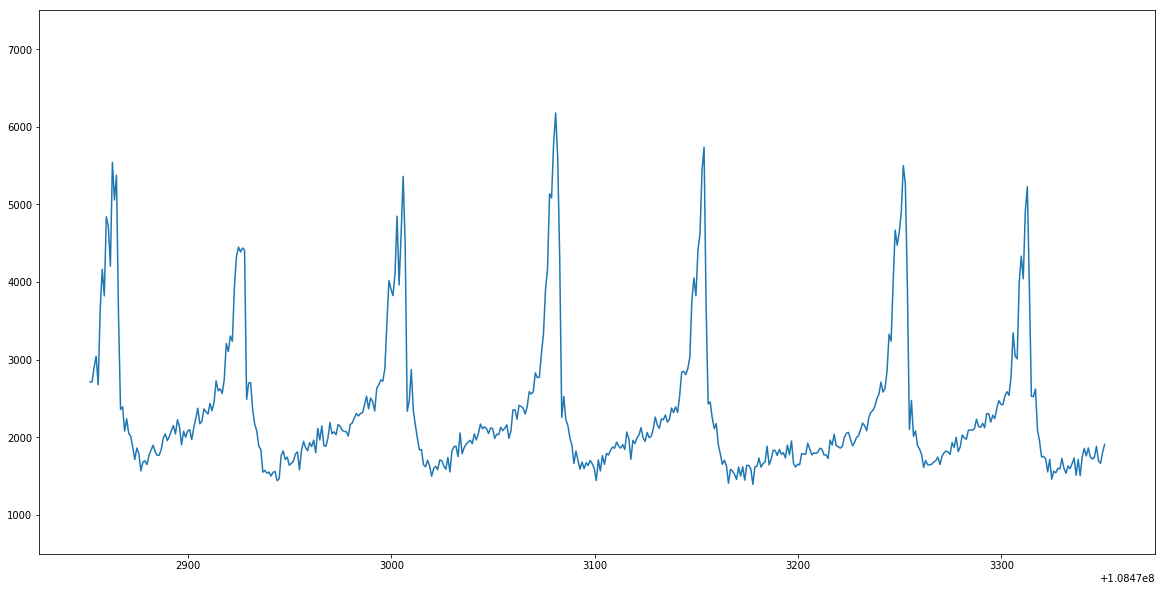

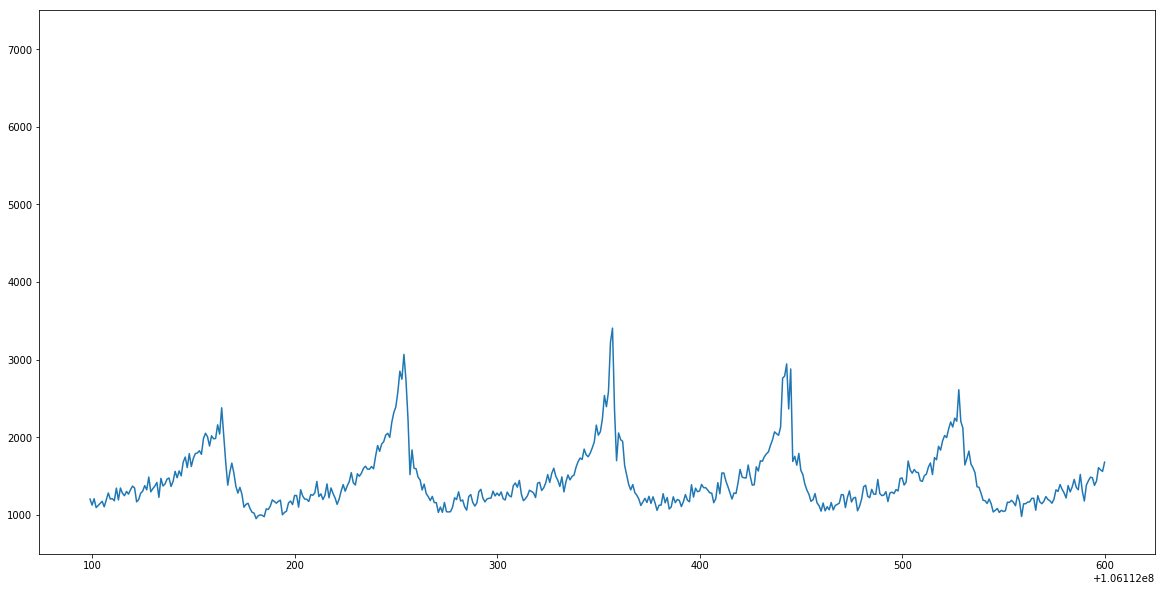

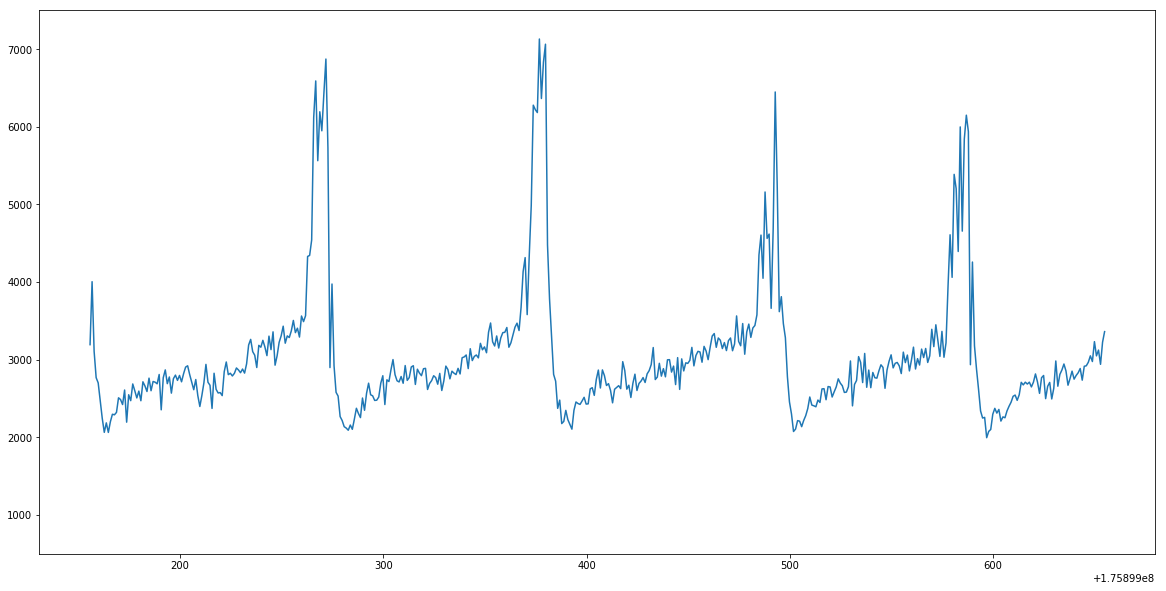

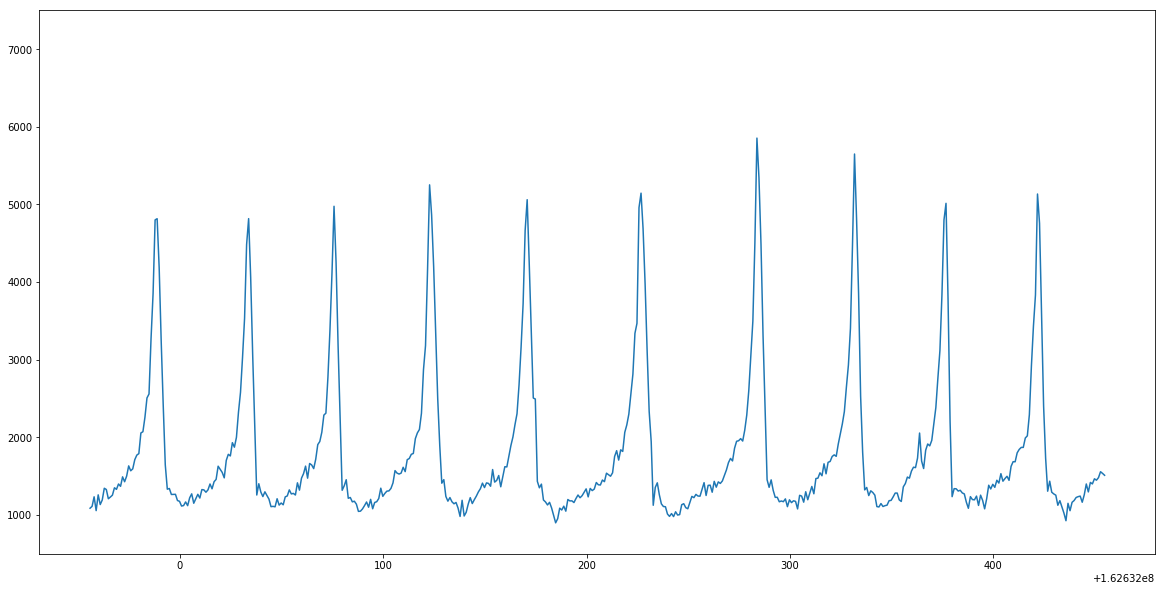

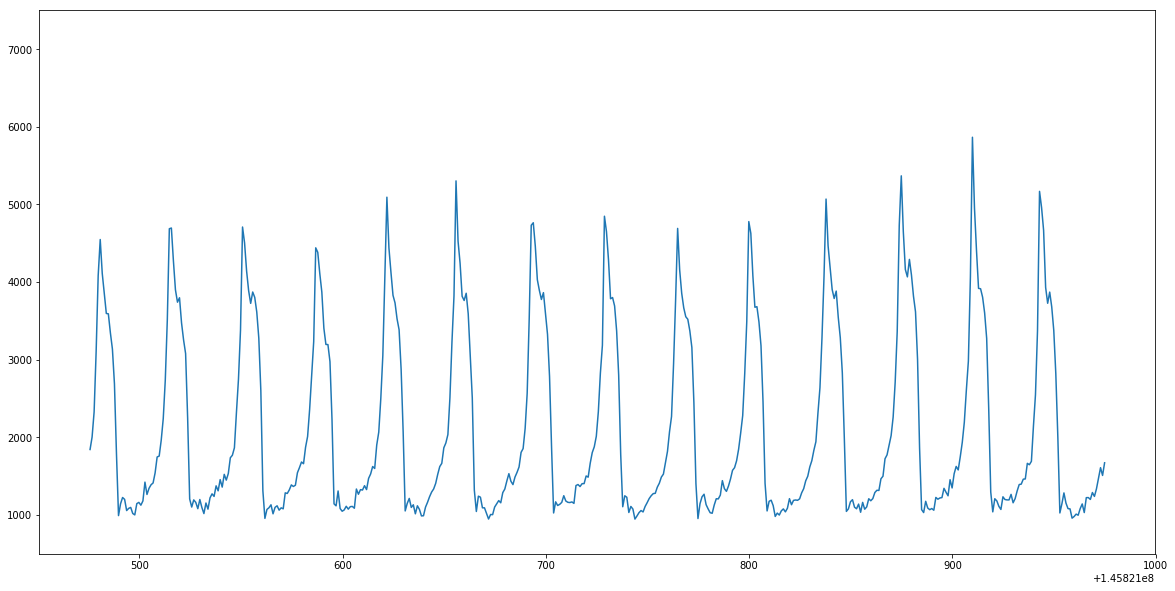

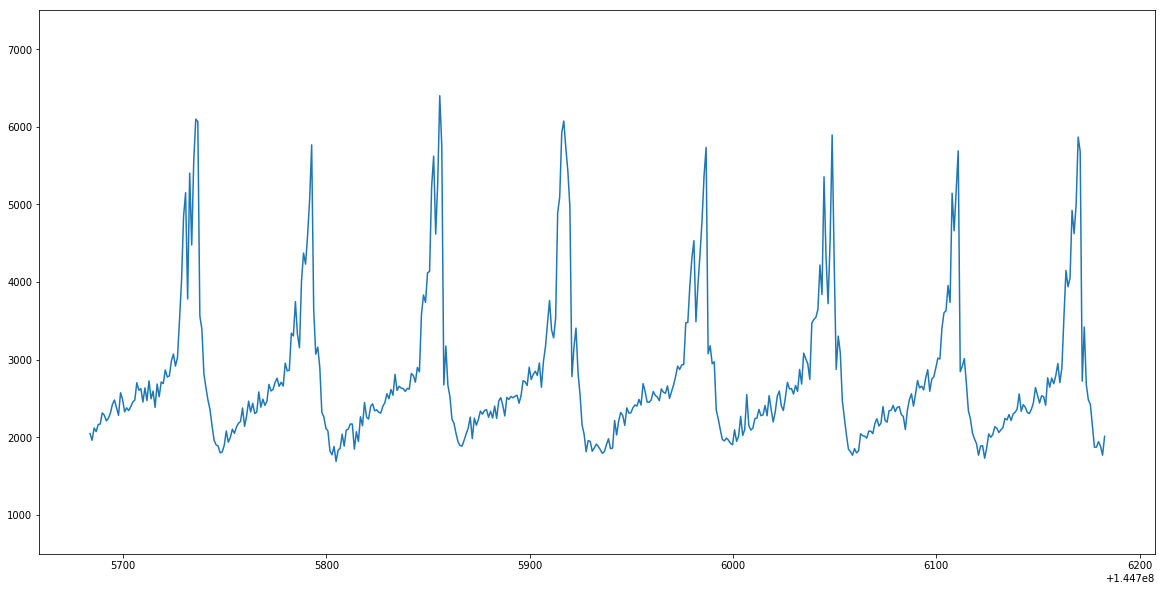

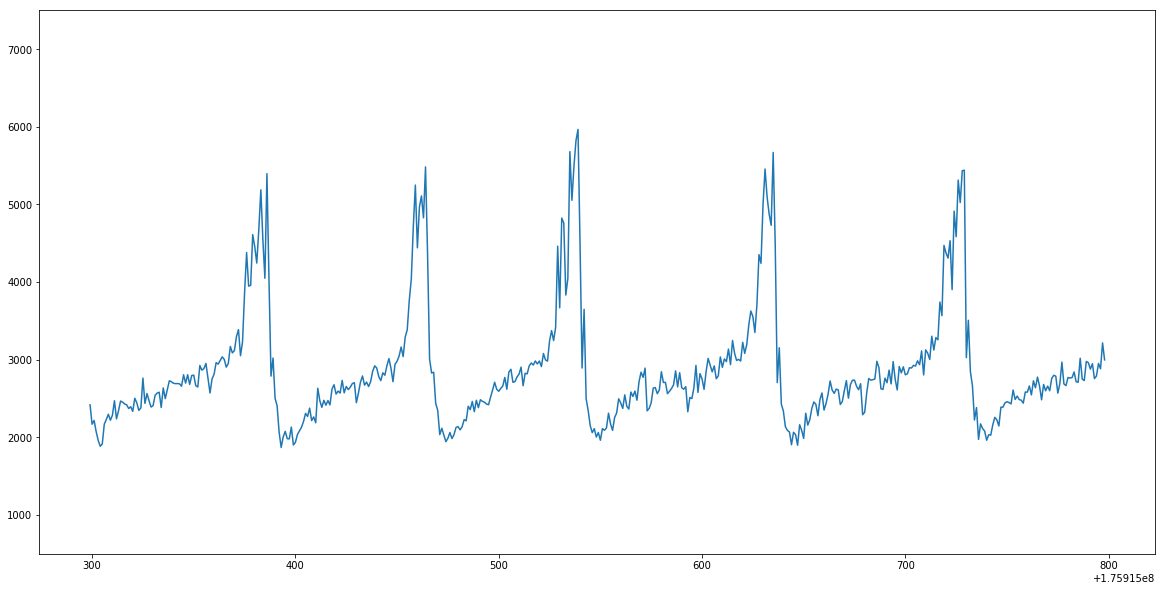

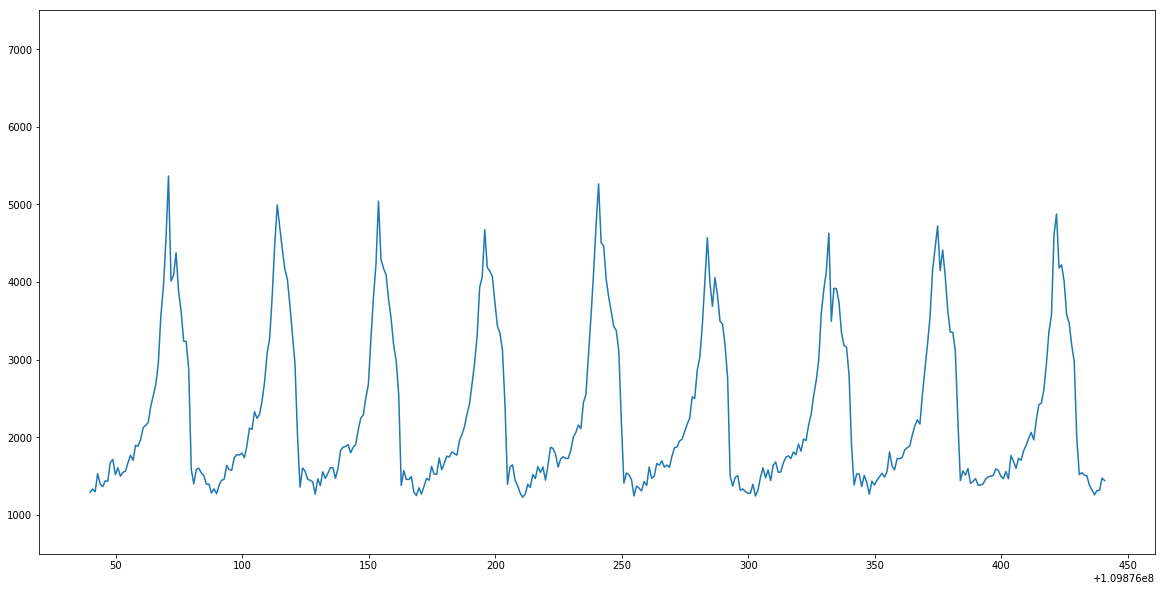

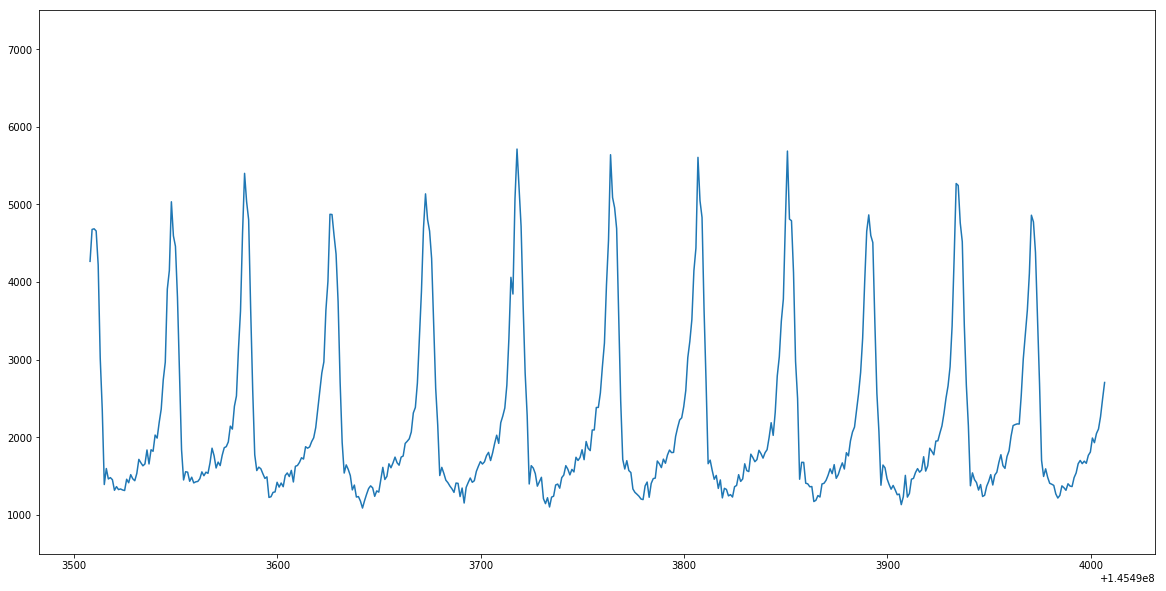

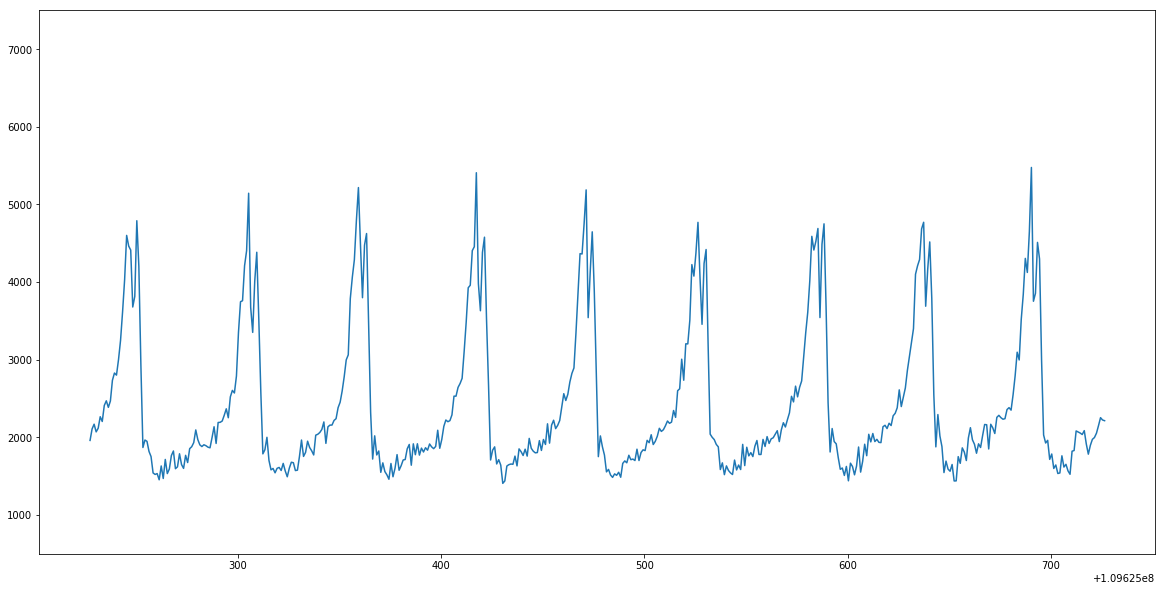

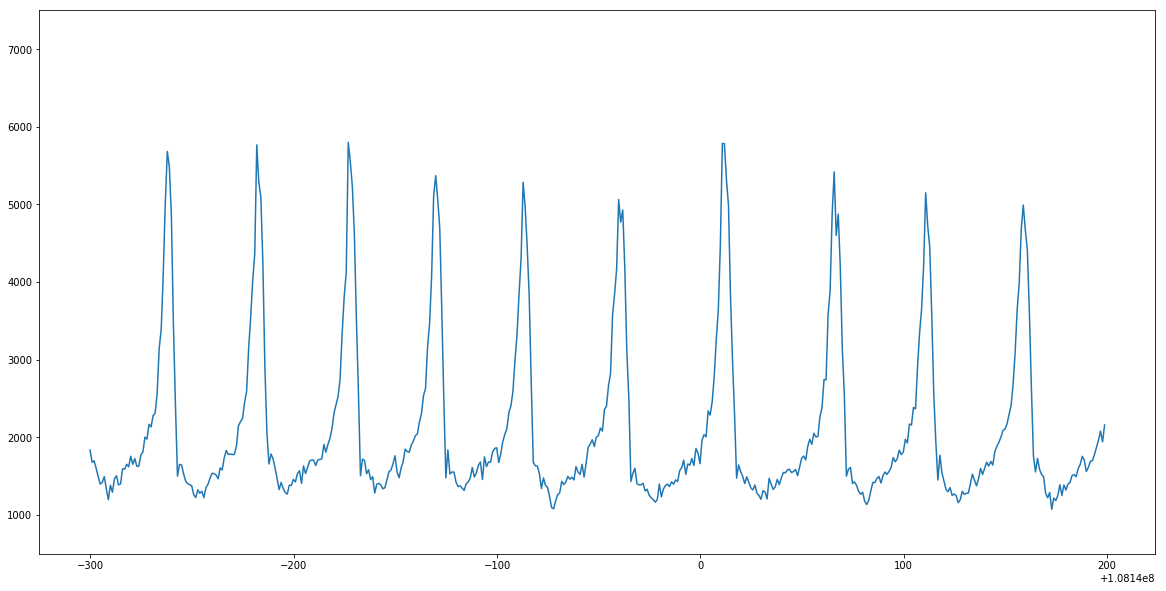

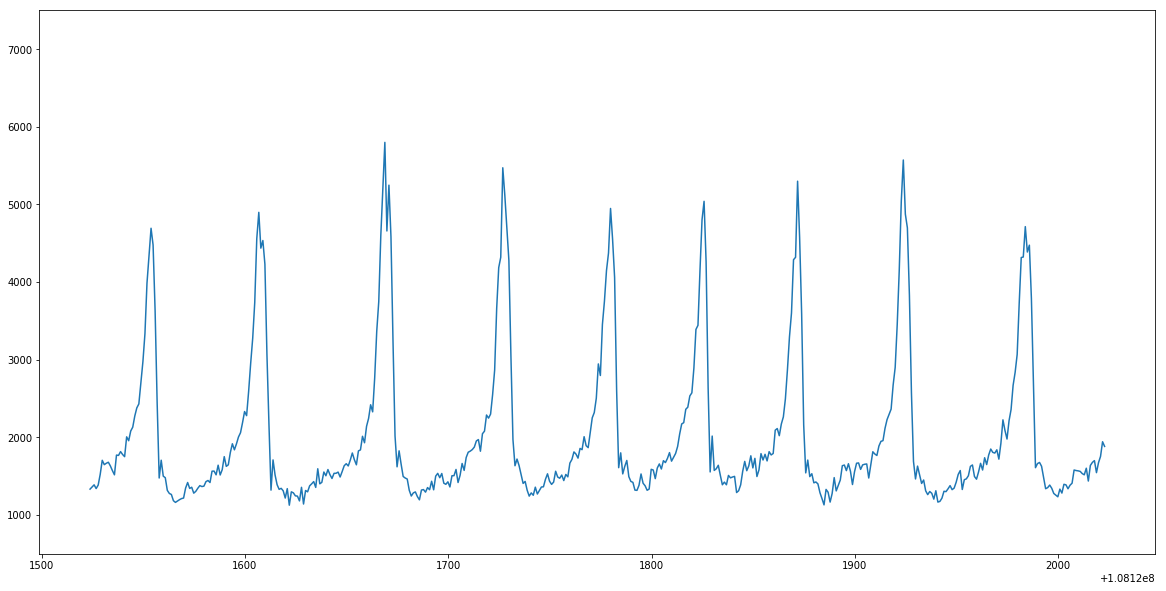

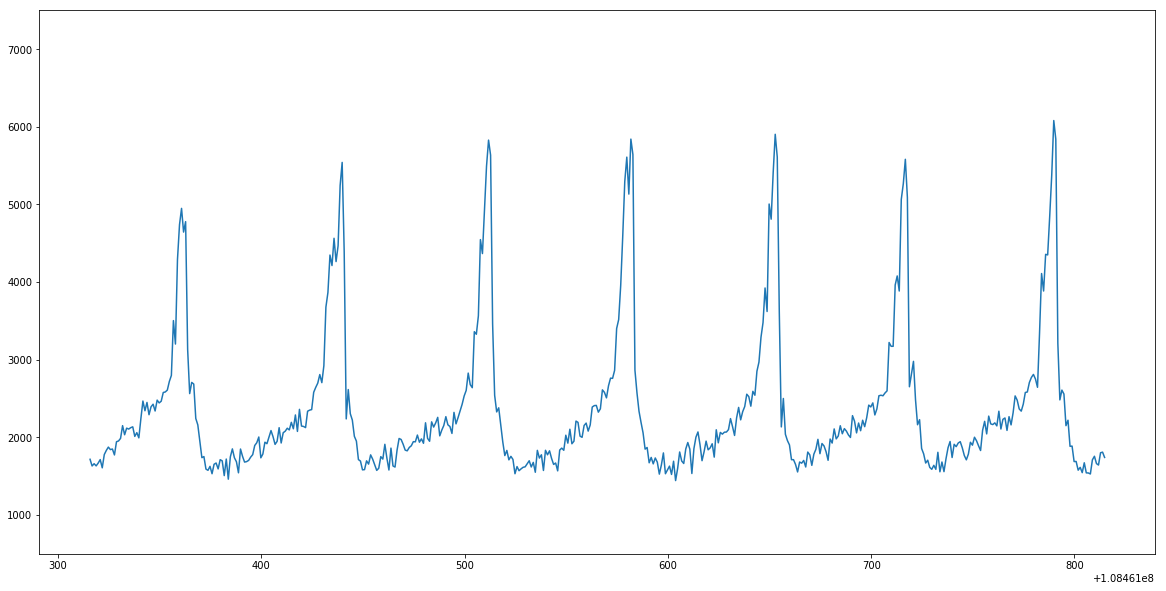

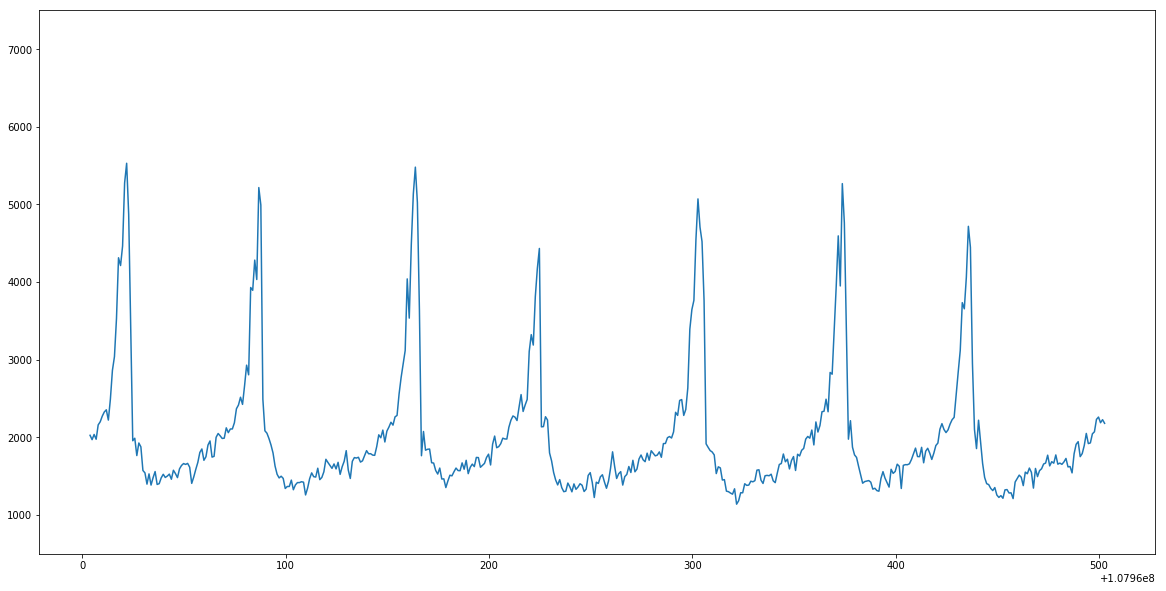

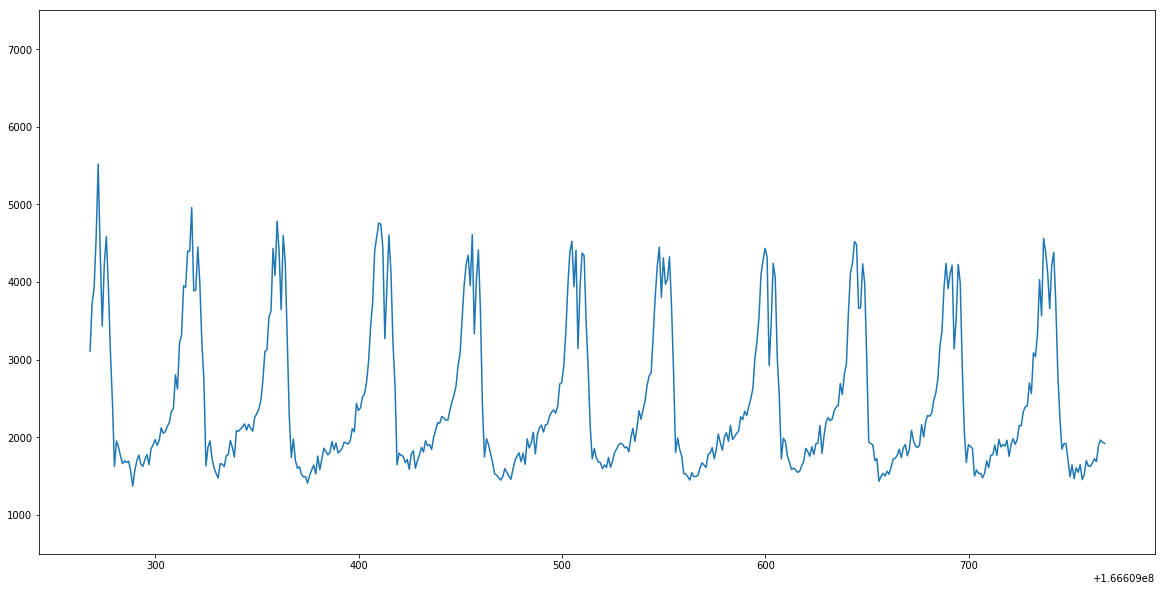

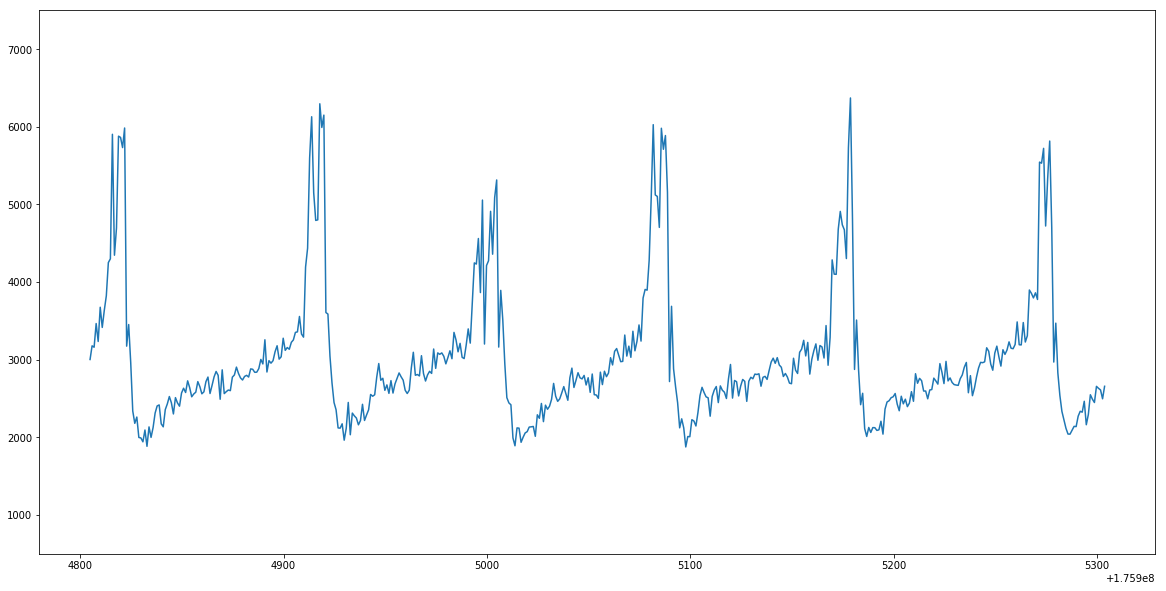

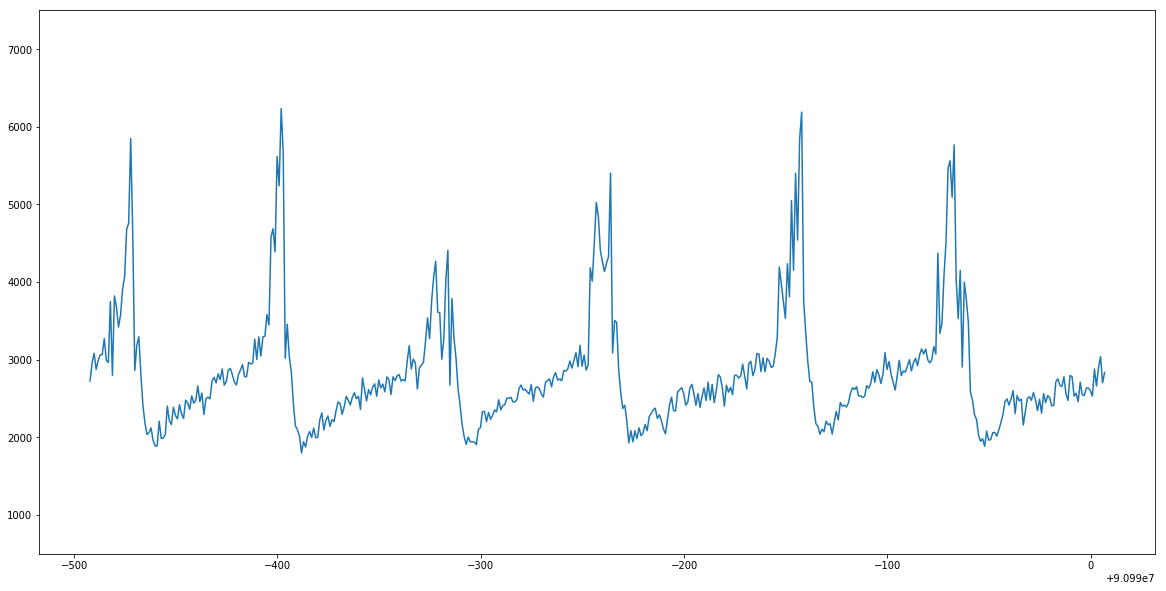

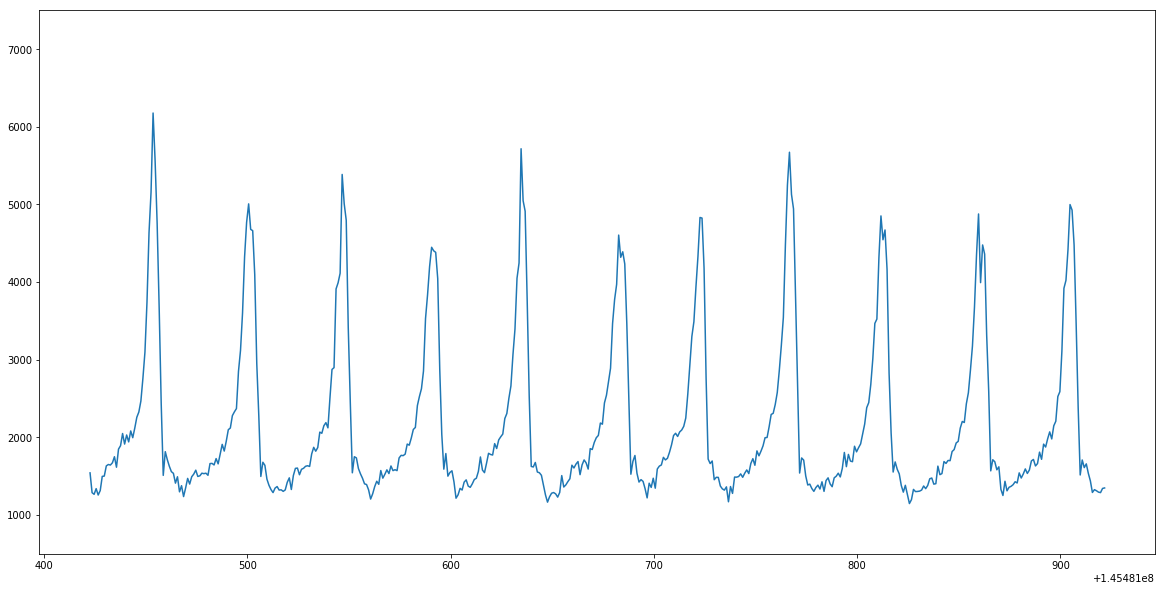

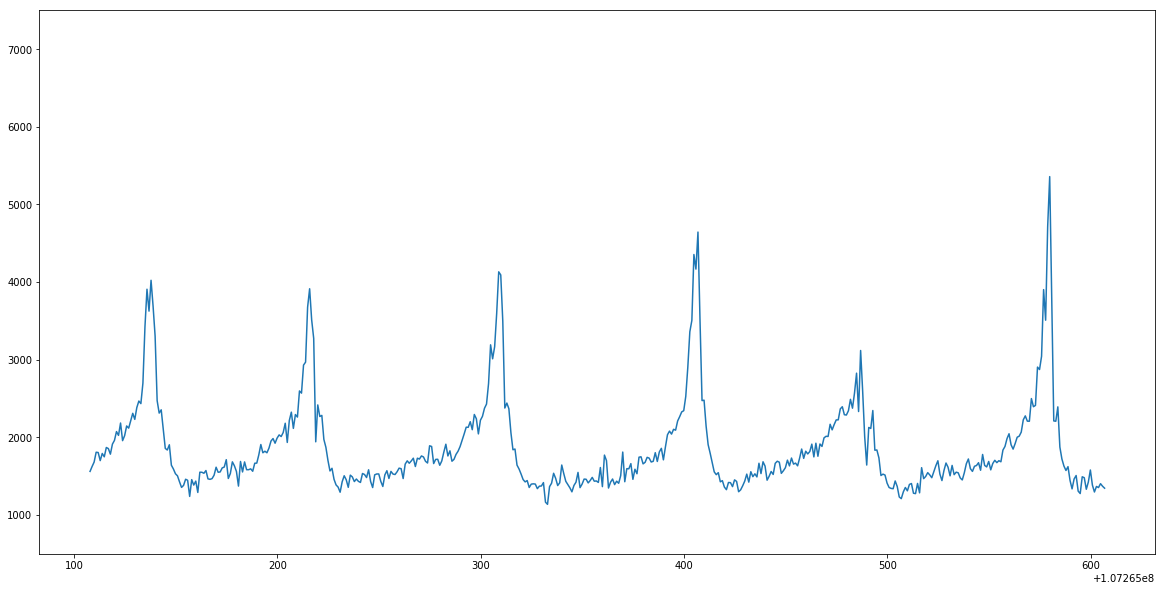

In [130]:
for ob_index, ob_id in enumerate(ids):
    ob_class=ob_state[ob_id]
    if ob_class == "rho":
        plt.figure(figsize=(20,10))
        xs=lcs[ob_index][0][0:500]
        ys=lcs[ob_index][1][0:500]
        plt.plot(xs,ys)
        
        mean_rate=np.mean(ys)
        std_rate=np.std(ys)
        min_rate=np.min(ys)
        max_rate=np.max(ys)
        #plt.plot([xs[0],xs[-1]],[mean_rate,mean_rate])
        plt.ylim([500,7500])
        #plt.plot([xs[0],xs[-1]],[mean_rate+std_rate,mean_rate+std_rate])
        plt.savefig("rho_lightcurves/real/{}.png".format(ob_id))
        #plt.show()

In [6]:
from sklearn.cluster import MeanShift

bandwidth=20
interval_treshold=170

interval_list=[]#intervals between centers of peaks, where peak is any count rate > mean+1sigma
thickness_list=[]#number of data points within each peak
max_peak_rate_list=[]#maximal count rate within each peak
std_peak_rate_list=[]#standard deviation of count rate within each peak
mean_peak_difference_list=[]#difference between mean count rates of each peak and the light curve mean
mean_rates_list=[]#mean count rates for the entire lighcurve
std_rates_list=[]#standard deviation of count rates for the entire lighcurve
for ob_index, ob_id in enumerate(ids):
    ob_class=ob_state[ob_id]
    if ob_class == "rho":
        xs=lcs[ob_index][0]#[0:500]
        ys=lcs[ob_index][1]#[0:500]
        
        mean_rate=np.mean(ys)
        std_rate=np.std(ys)
        mean_rates_list.append(mean_rate)
        std_rates_list.append(std_rate)
        
        #### find the intervals between peaks
        peaks_indices=np.where(ys>mean_rate+std_rate)[0]
        peaks_time=xs[peaks_indices]
        
        clusters = MeanShift(bandwidth=bandwidth).fit(peaks_time.reshape(-1, 1))
        centers=np.sort(clusters.cluster_centers_.T[0])
        
#         plt.scatter(peaks_time,np.zeros(len(peaks_time)))
#         plt.scatter(clusters.cluster_centers_, np.ones(len(clusters.cluster_centers_)))
        
        intervals=centers[1:]-centers[:-1]
        centers=np.sort(clusters.cluster_centers_.T[0])
        intervals=centers[1:]-centers[:-1]
        GTI=np.where(intervals<interval_treshold)[0]
        interval_list.append(intervals[GTI])
        
        ### find the width of the peaks
        thickness_list.append(np.unique(clusters.labels_,return_counts=True)[1])
        
        ### find the magnitude of the peaks
        peaks_mags=ys[peaks_indices]
        for cluster_ind in set(clusters.labels_):
            cluster_mags=peaks_mags[np.where(clusters.labels_==cluster_ind)[0]]
            max_peak_rate_list.append(np.max(cluster_mags))
            std_peak_rate_list.append(np.std(cluster_mags))
            mean_peak_difference_list.append(np.mean(cluster_mags)-mean_rate)

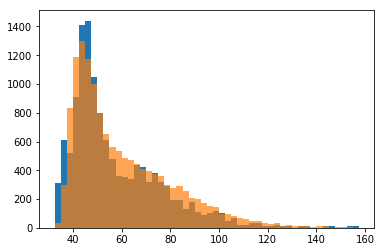

In [226]:
from sklearn.mixture import GaussianMixture
plt.hist(np.repeat(np.hstack(interval_list),10), bins=50, range=(32.5,157.5))
GM=GaussianMixture(n_components=2, covariance_type='full').fit(np.hstack(interval_list).reshape(-1, 1))
GM_generate=np.hstack(GM.sample(len(np.hstack(interval_list)))[0])
gamma1=np.random.gamma(4.5, 3, 7000)+32.5
gamma2=np.random.gamma(5, 8.5, 7000)+32.5
normal1=np.random.normal(44, 6, 700)
normal2=np.random.normal(67.5, 20, 700)
normal=np.random.normal(mean_interval, std_interval, 14000)
gamma=np.concatenate((gamma1,gamma2))
plt.hist(gamma, bins=50, alpha=0.7, range=(32.5,157.5))
plt.show()

In [225]:
from scipy.stats import gamma
x = np.linspace(0,200,num=1000)
dist=gamma(4.5,0, 3)
gamma.pdf(x)
# plt.plot(x,gamma.pdf(x))

TypeError: _parse_args() missing 1 required positional argument: 'a'

In [131]:
gamma1=np.random.gamma(4.5, 3, 7000)+32.5
gamma2=np.random.gamma(5, 8.5, 7000)+32.5
gamma=np.concatenate((gamma1,gamma2))
generate_rhos=1000
synthetic_rhos=np.zeros((generate_rhos, 500))
gen_x=np.linspace(0,699,num=700)
for gen_rho in range(generate_rhos):
    gen_y=np.zeros(len(gen_x))
    gen_mean=np.random.normal(np.mean(mean_rates_list), np.std(mean_rates_list))
    gen_interval=np.random.choice(gamma)
    peak_thickness=np.random.normal(np.mean(np.hstack(thickness_list)),np.std(np.hstack(thickness_list)))
    mean_difference=np.random.normal(np.mean(np.hstack(mean_peak_difference_list)),np.std(np.hstack(mean_peak_difference_list)))
    peak_std=np.random.choice(np.hstack(std_peak_rate_list))

    #np.random.choice((np.hstack(std_peak_rate_list)))
    gen_std=np.random.normal(np.mean(np.hstack(std_rates_list)),np.std(np.hstack(std_rates_list)))
    gen_trough=gen_mean-gen_std
                              
    
    noise=np.random.normal(0,100 ,len(gen_y))
    gen_y+=gen_mean+noise
    
    peak_interval=np.random.choice(gamma)
    peak_position=0
    while peak_position<len(gen_y)-peak_interval-1:
        peak_position+=peak_interval+np.random.normal(0,3,1)
        half_thickness=int(round((peak_thickness+np.random.normal(0,0.5 ,1)[0])/2,0))
        peak_position=int(peak_position)
        start=peak_position-half_thickness
        end=peak_position+half_thickness
        gen_y[start:end]=np.random.normal(gen_mean+mean_difference,peak_std,len(gen_y[peak_position-half_thickness:peak_position+half_thickness])) 
        peak_pi=np.linspace(0,np.pi, len(gen_y[start:end]))
        peak_sin=np.sin(peak_pi)
        peak_min=np.min(gen_y[start:end])
        gen_y[start:end]=(gen_y[start:end]-peak_min) *peak_sin +peak_min
        
        gen_y[end:int(end+peak_interval)]-=np.linspace(gen_trough,0, len(gen_y[end:int(end+peak_interval)]))
    
    
    gen_y=(gen_y-np.mean(gen_y))*(gen_std/np.std(gen_y))
    gen_y+=gen_mean
        
    
    save=np.random.randint(int(peak_interval),200)
    synthetic_rhos[gen_rho,:]=gen_y[save:save+500]
    #mean_ori+(pred_centroid-mean_pred)*(std_ori/std_pred)
    
    ############scale std of the light curve and center the peak more

    # interval_list=[]#intervals between centers of peaks, where peak is any count rate > mean+1sigma
    # thickness_list=[]#number of data points within each peak
    # max_peak_rate_list=[]#maximal count rate within each peak
    # std_peak_rate_list=[]#standard deviation of count rate within each peak
    # mean_peak_difference_list=[]#difference between count rates of each peak and the light curve mean
    # mean_rates_list=[]#mean count rates for the entire lighcurve
    # std_rates_list=[]#standard deviation of count rates for the entire lighcurve
    

/home/jkok1g14/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


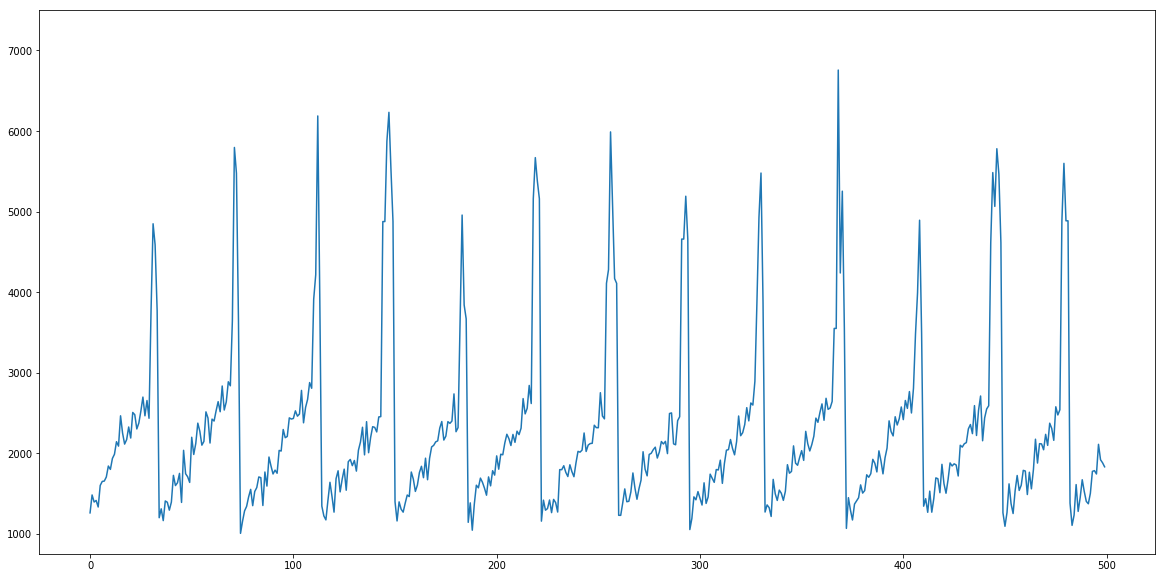

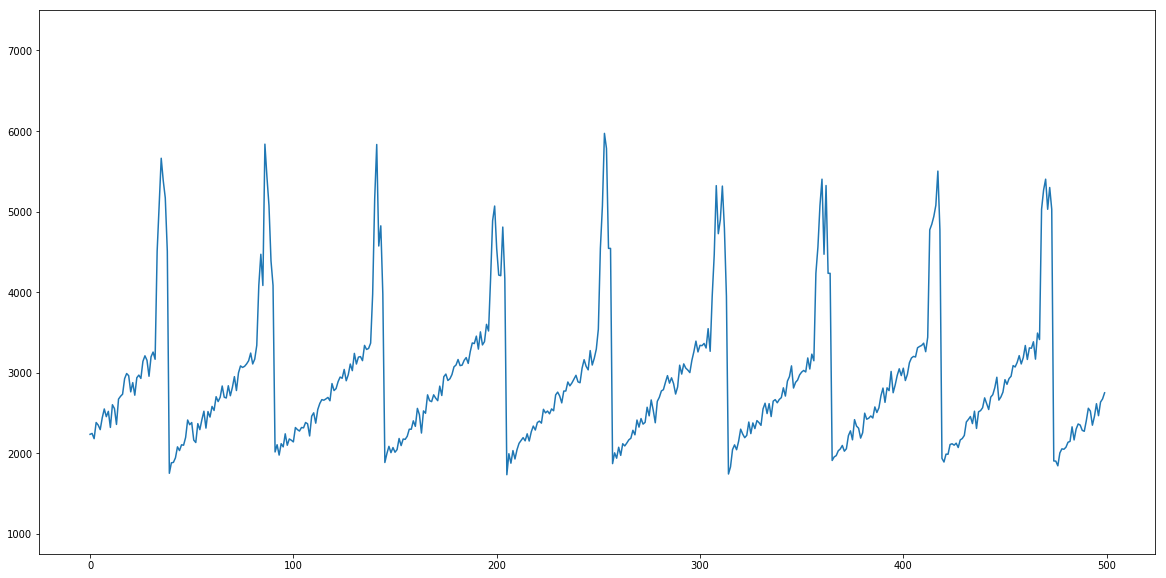

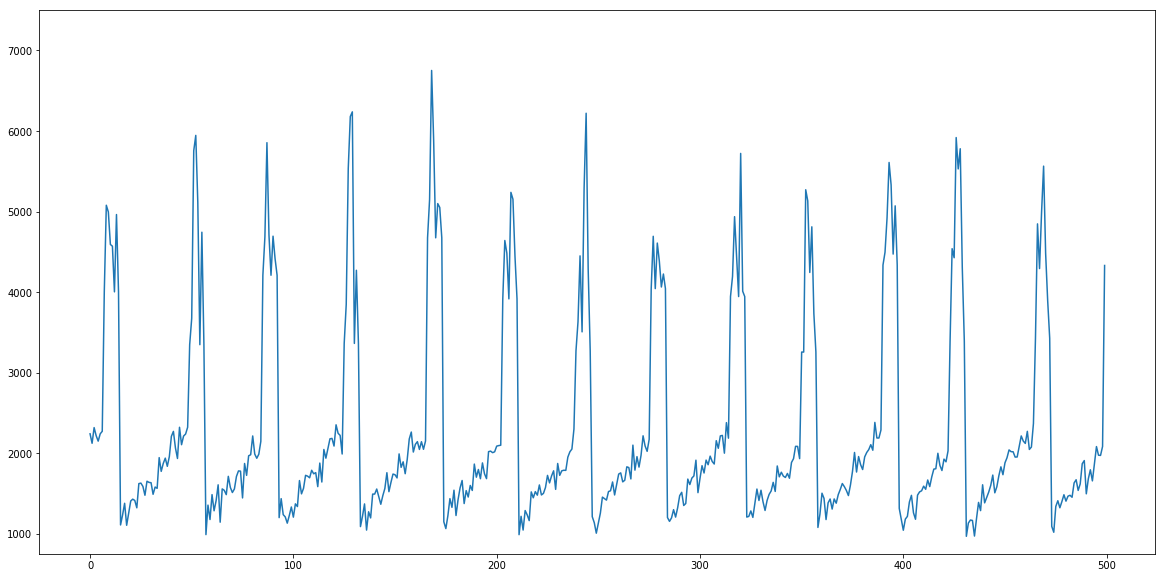

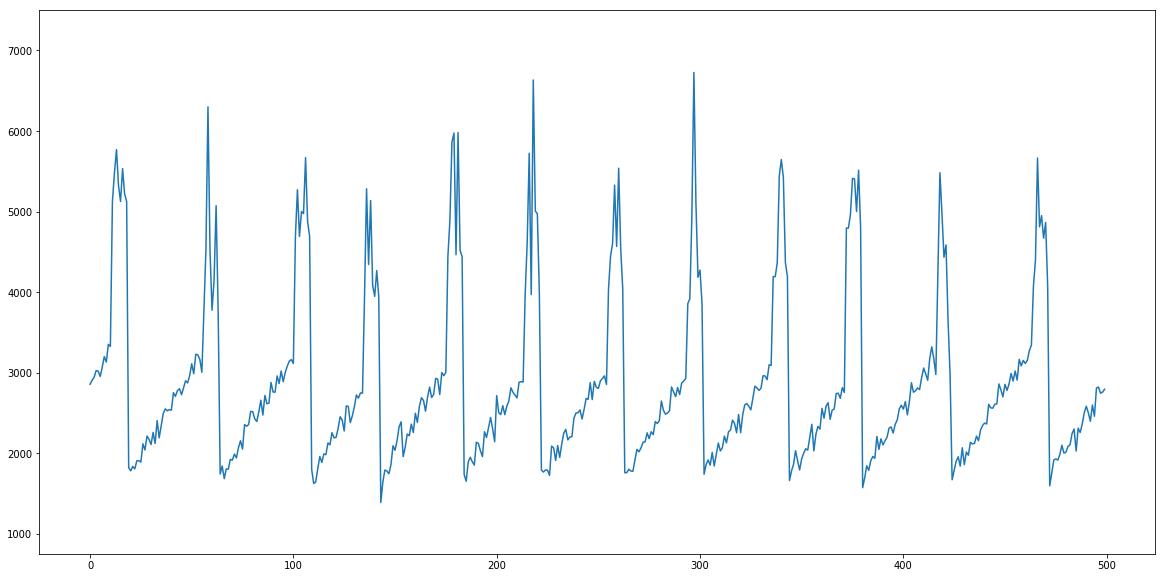

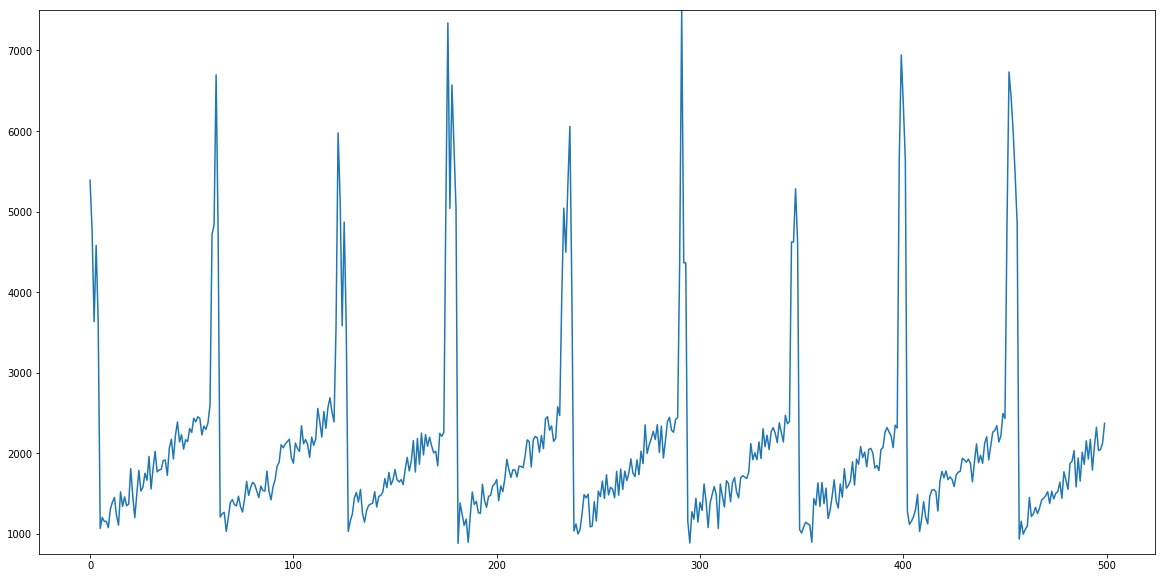

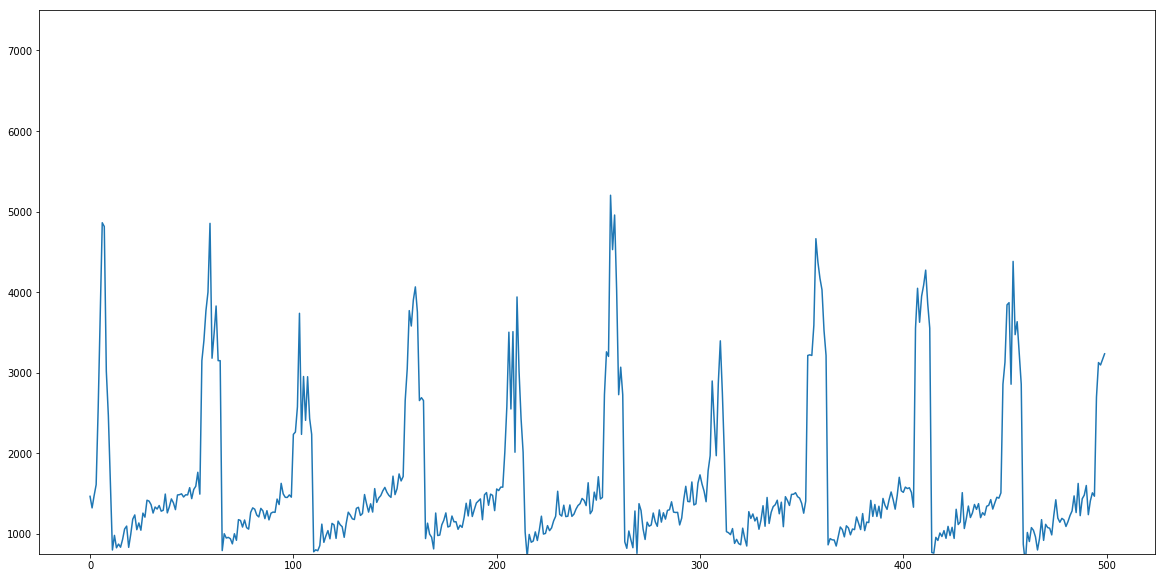

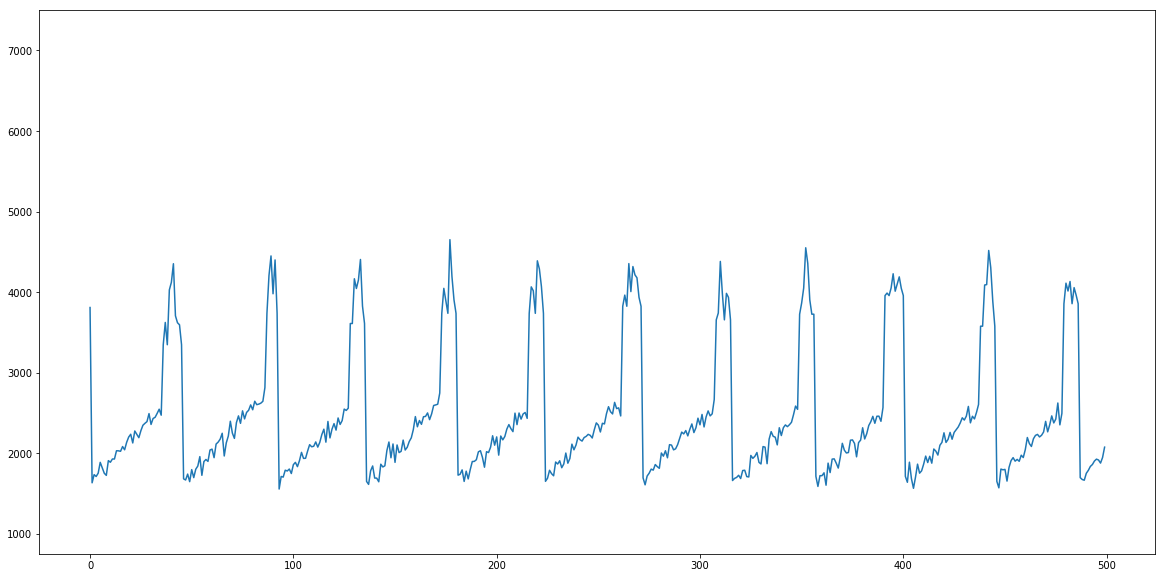

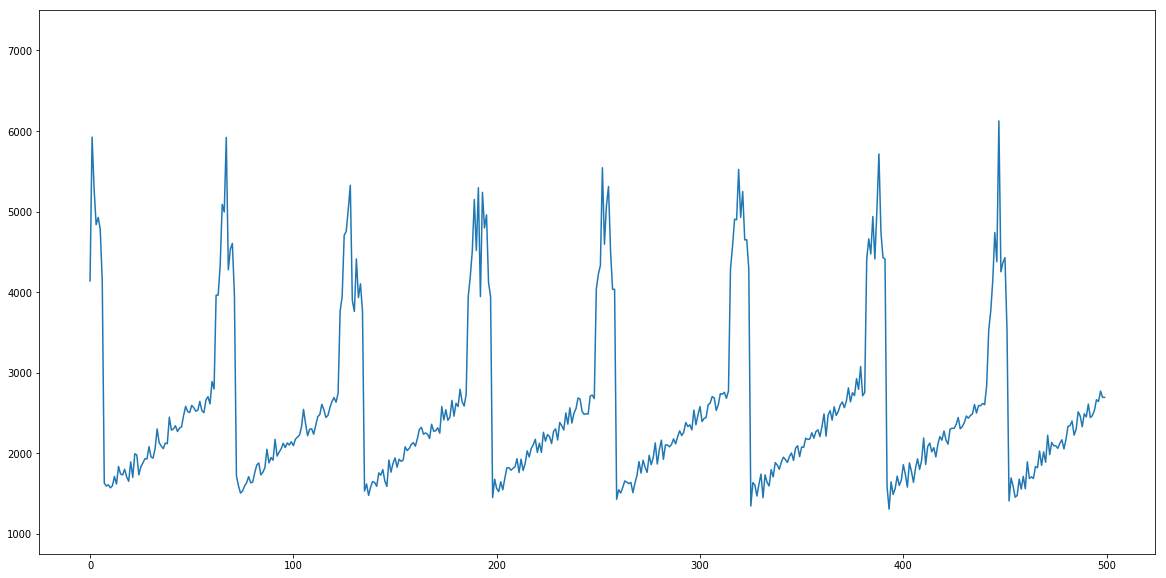

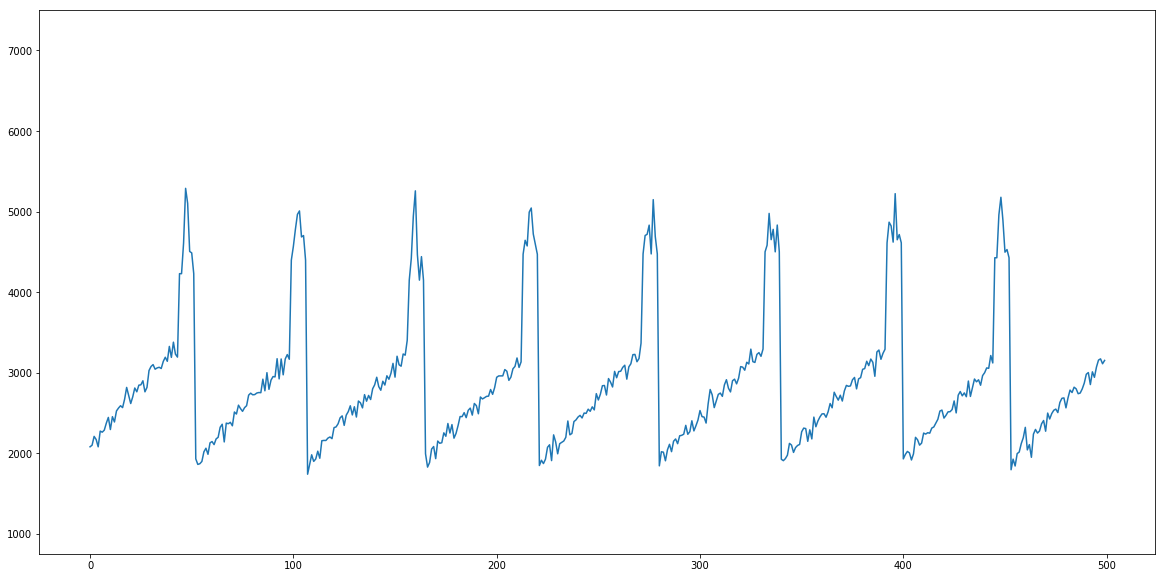

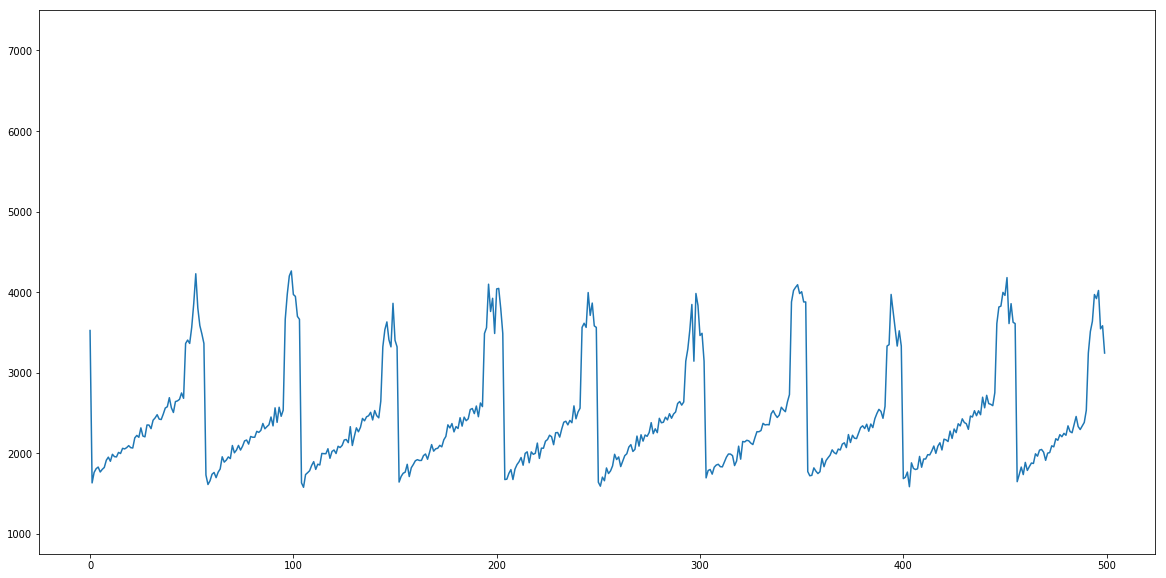

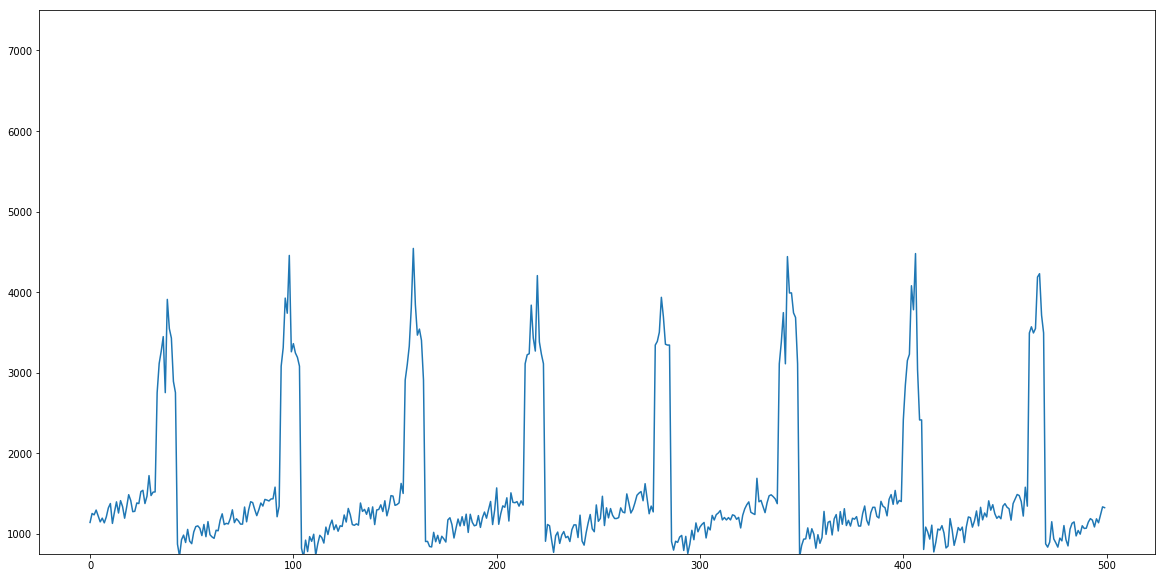

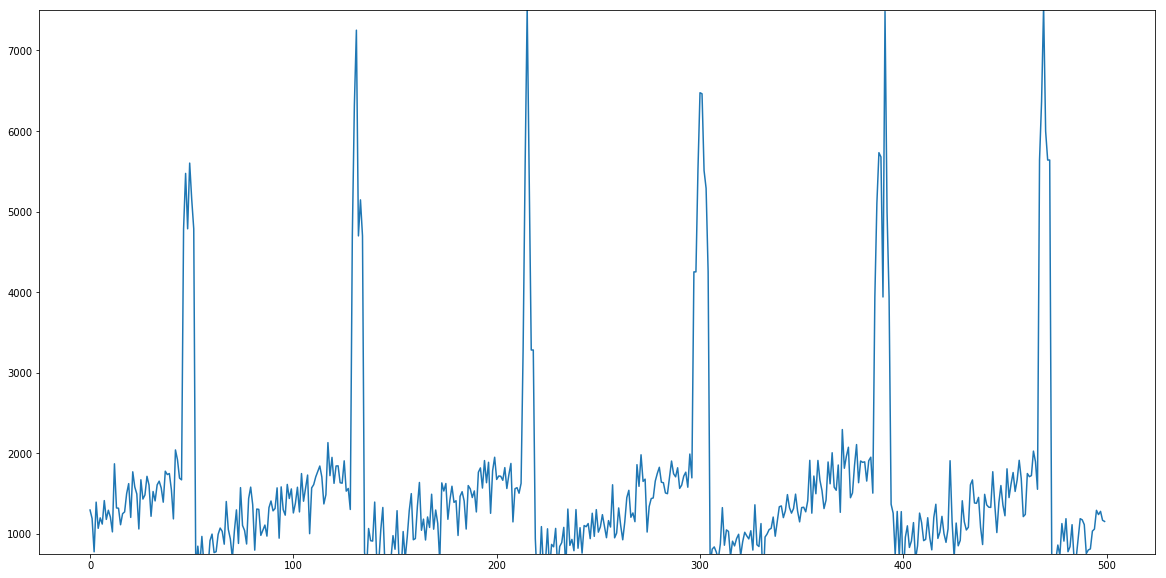

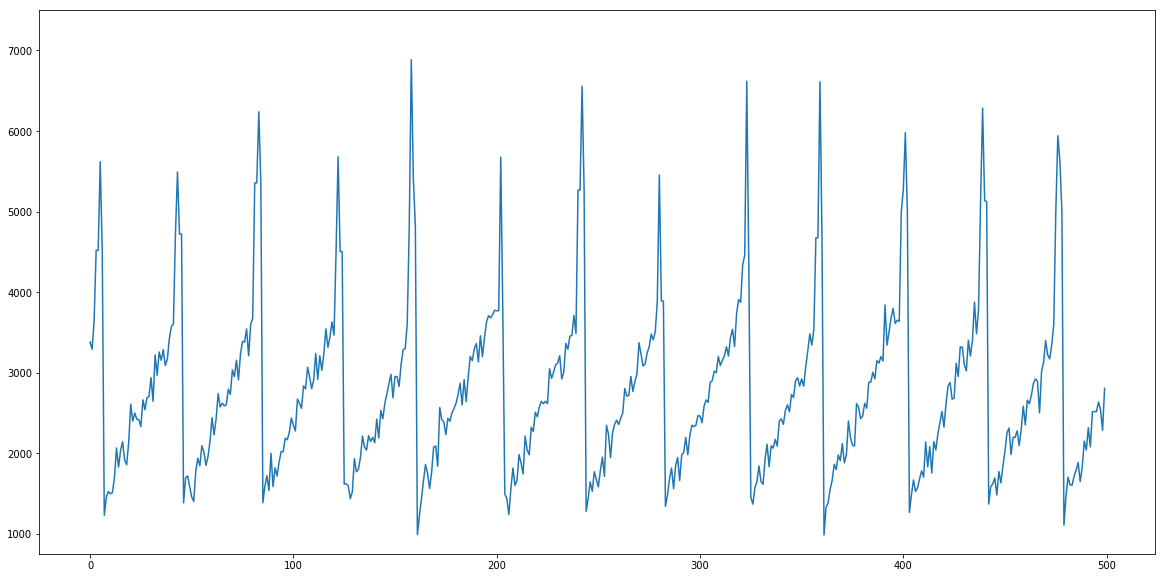

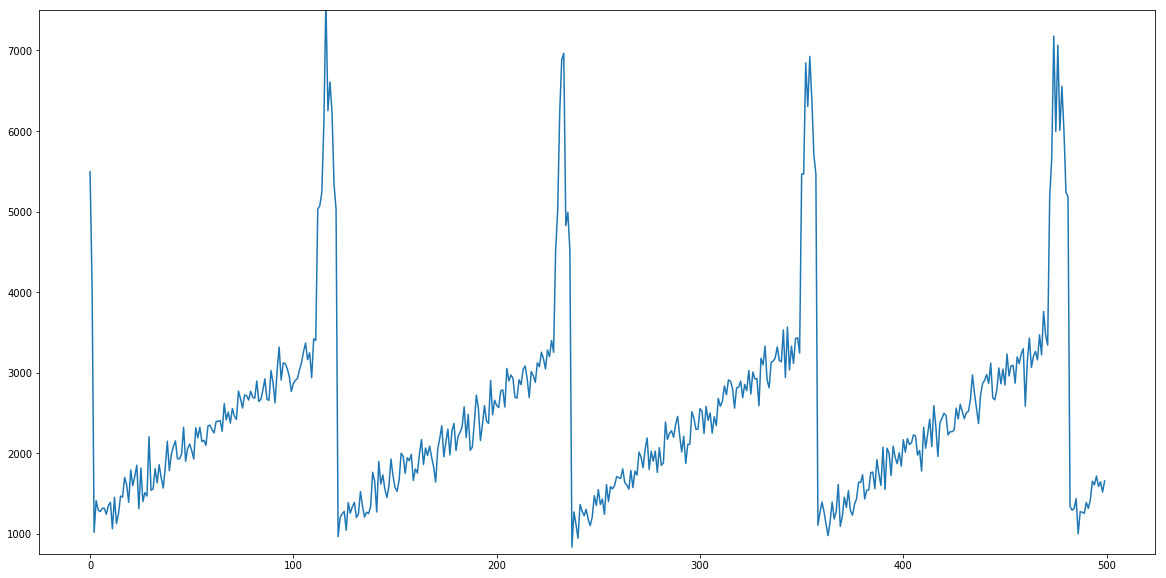

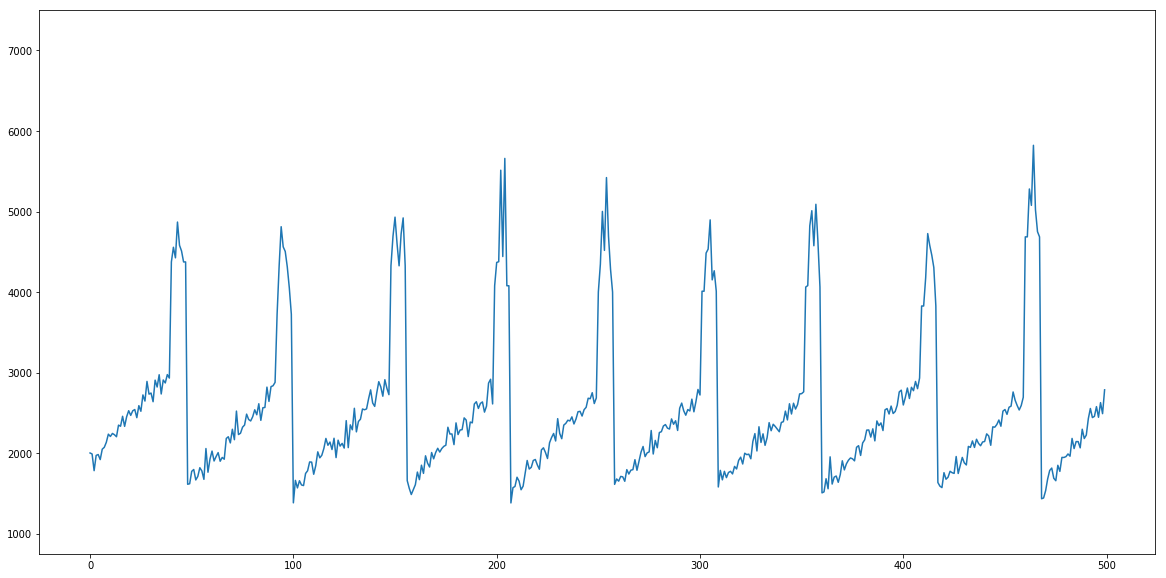

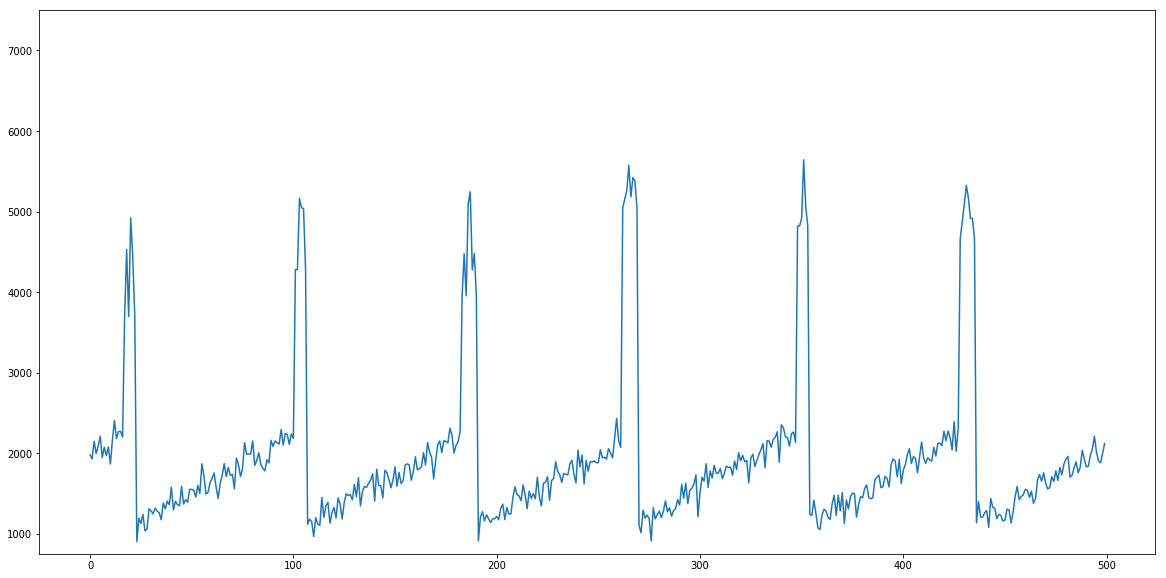

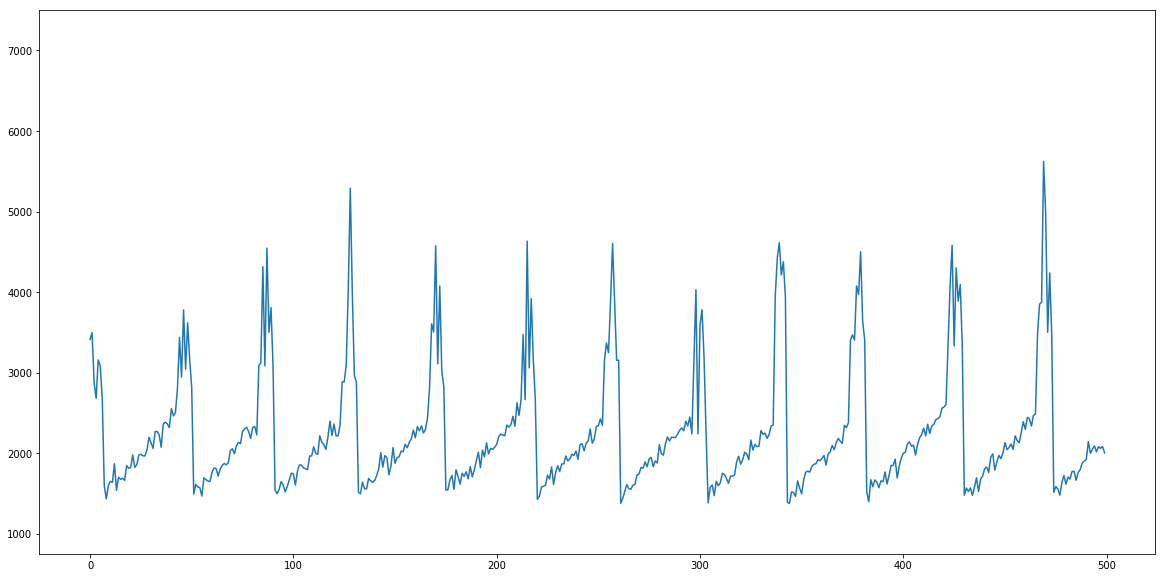

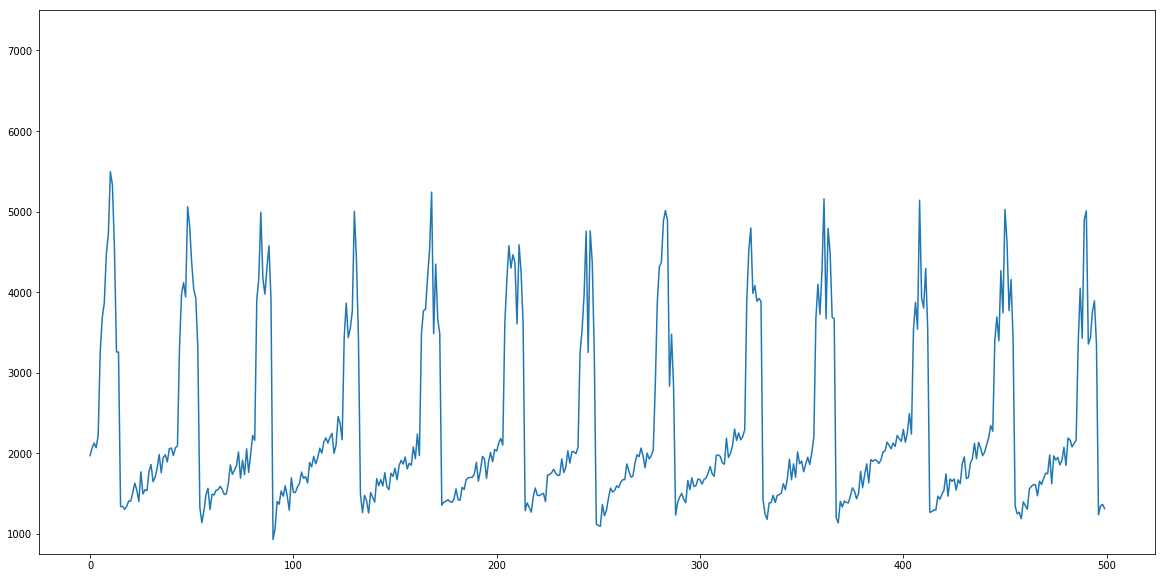

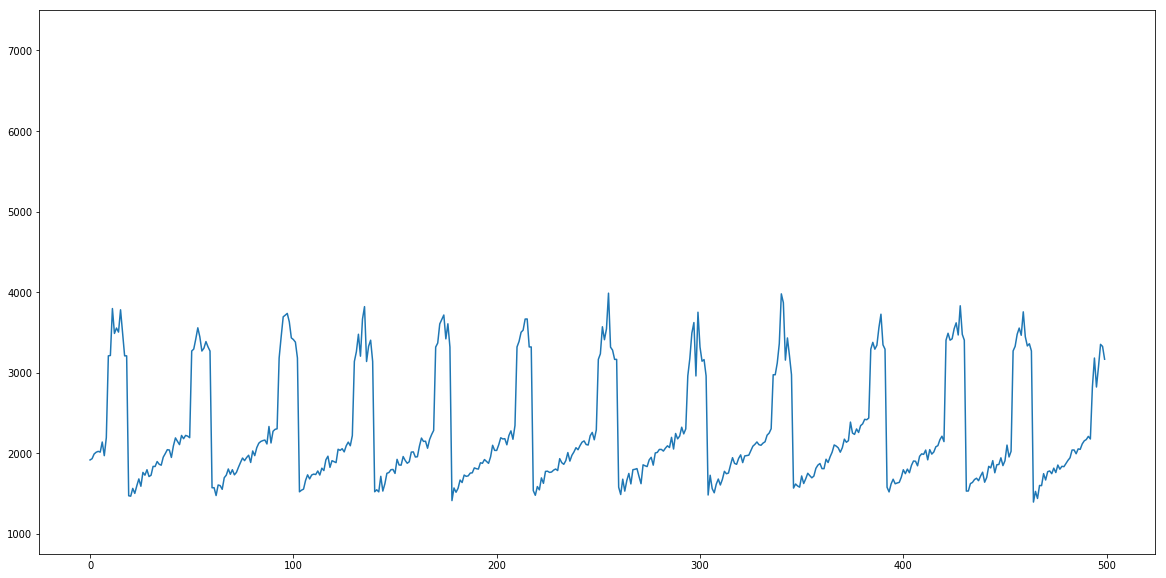

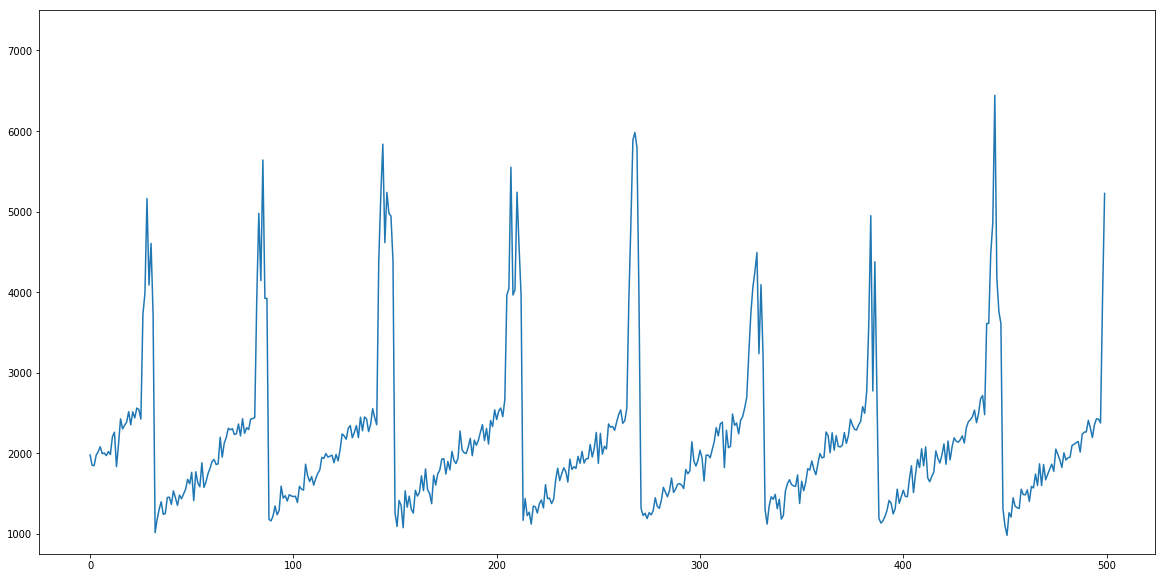

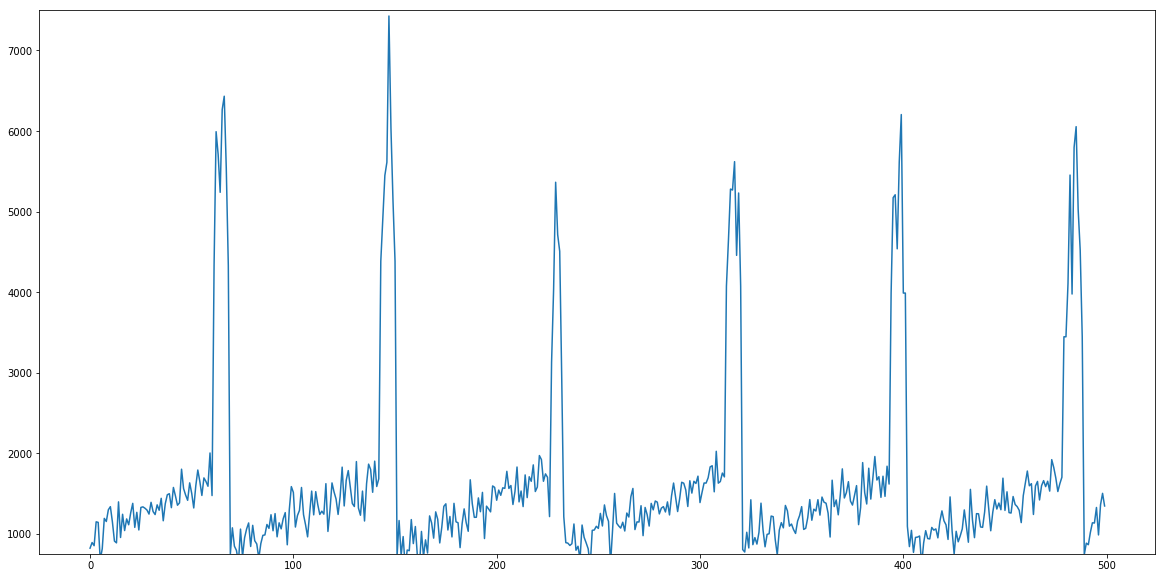

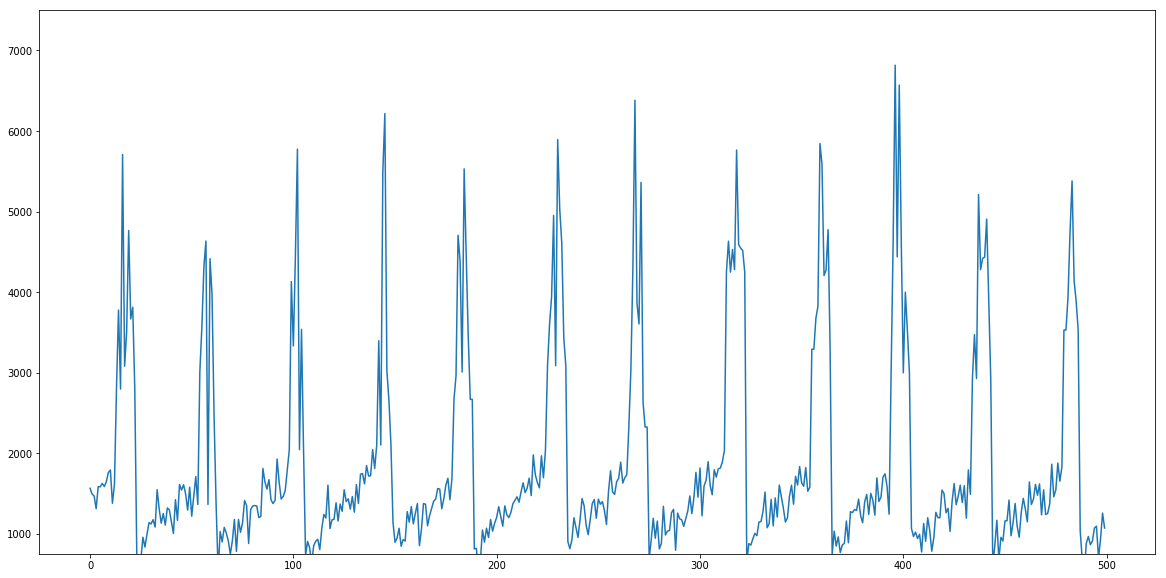

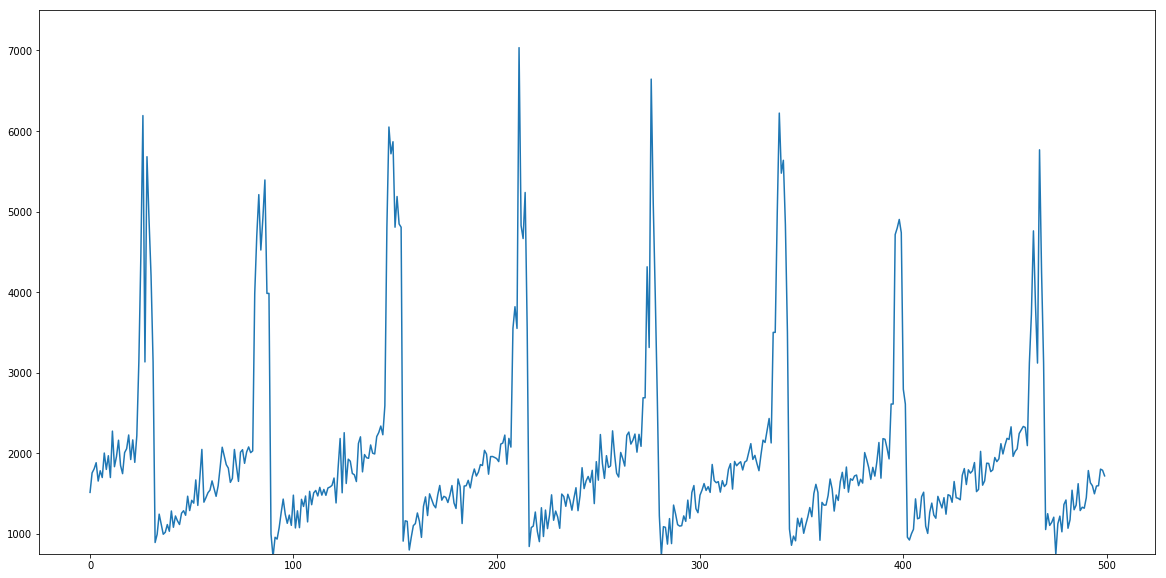

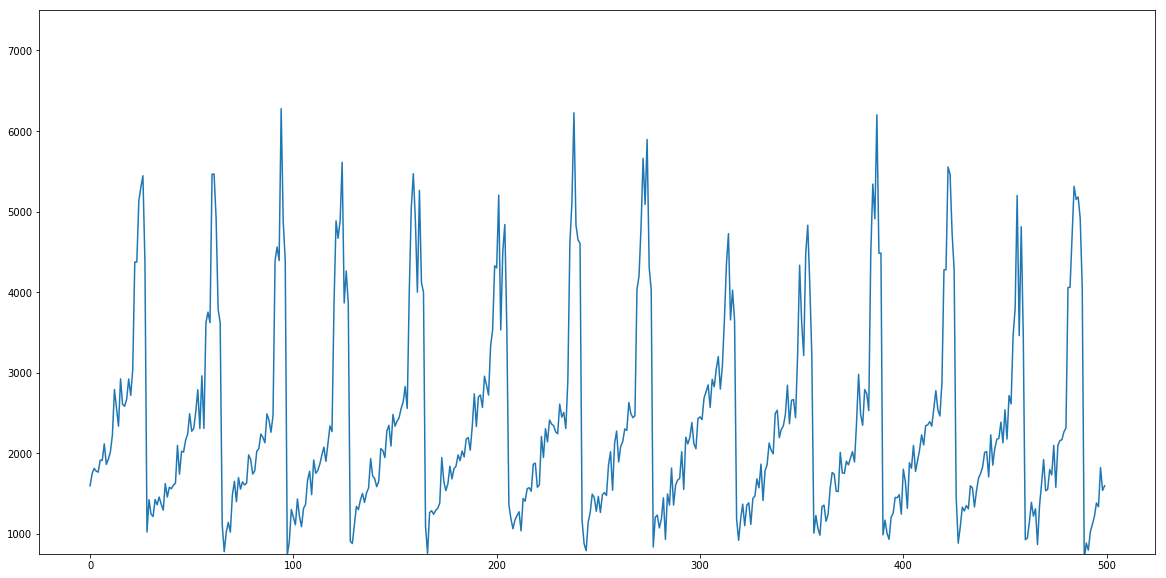

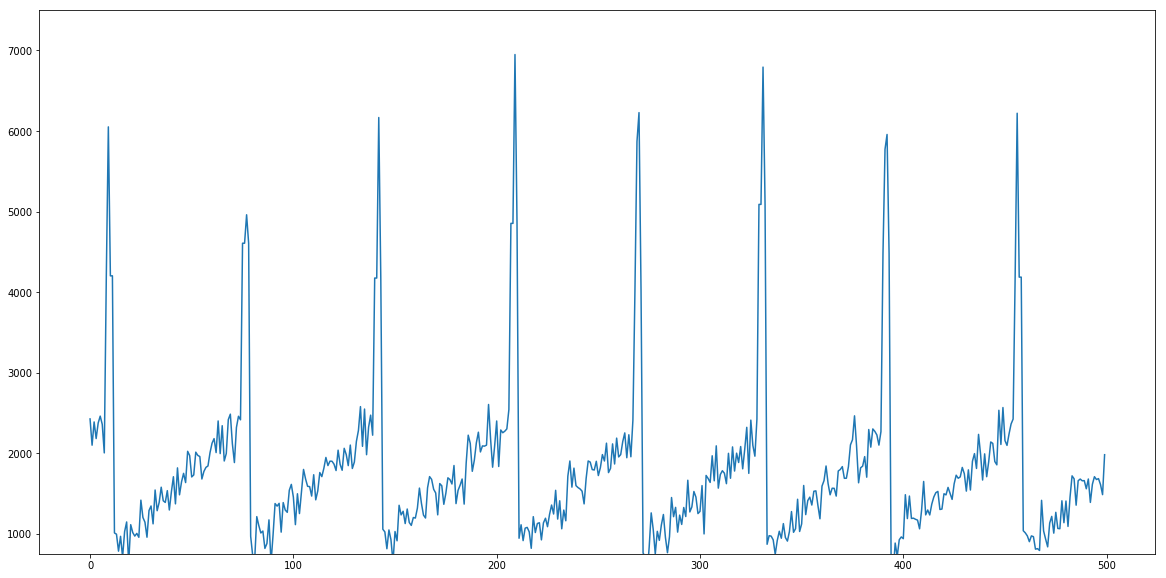

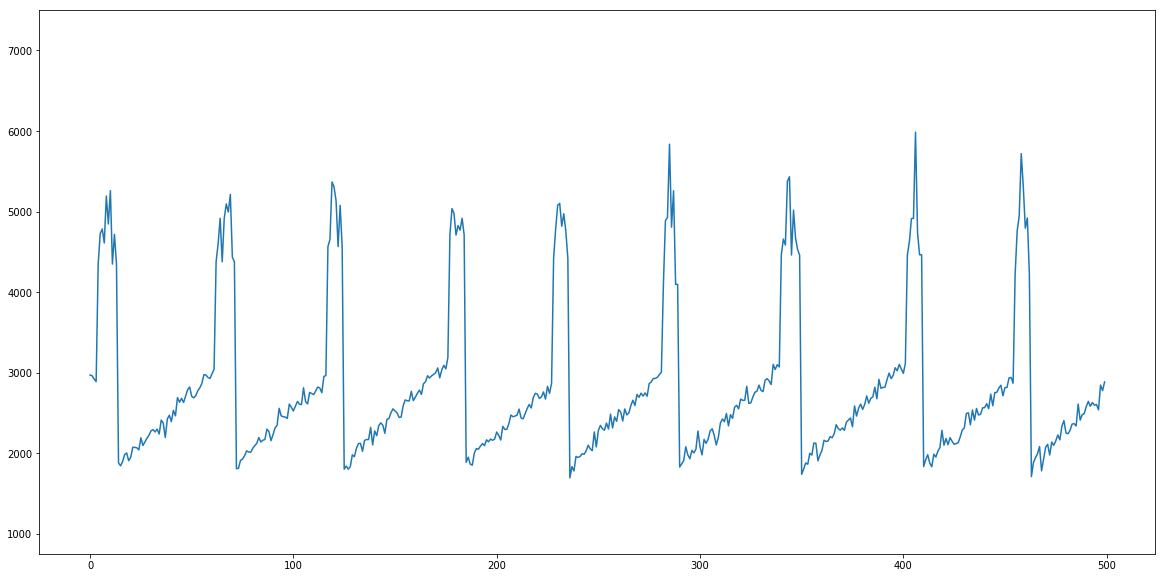

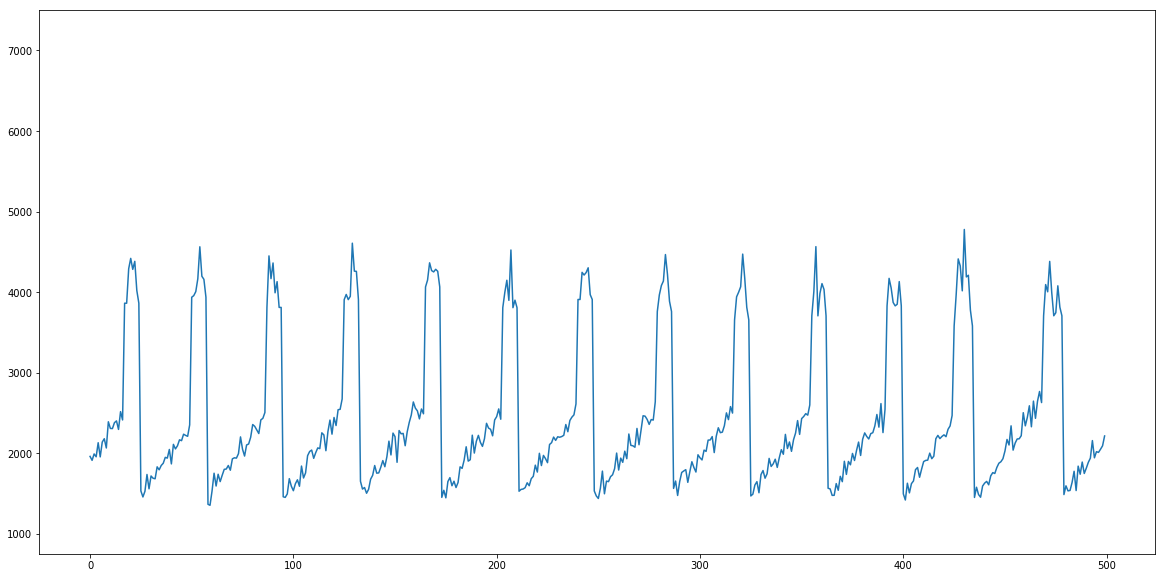

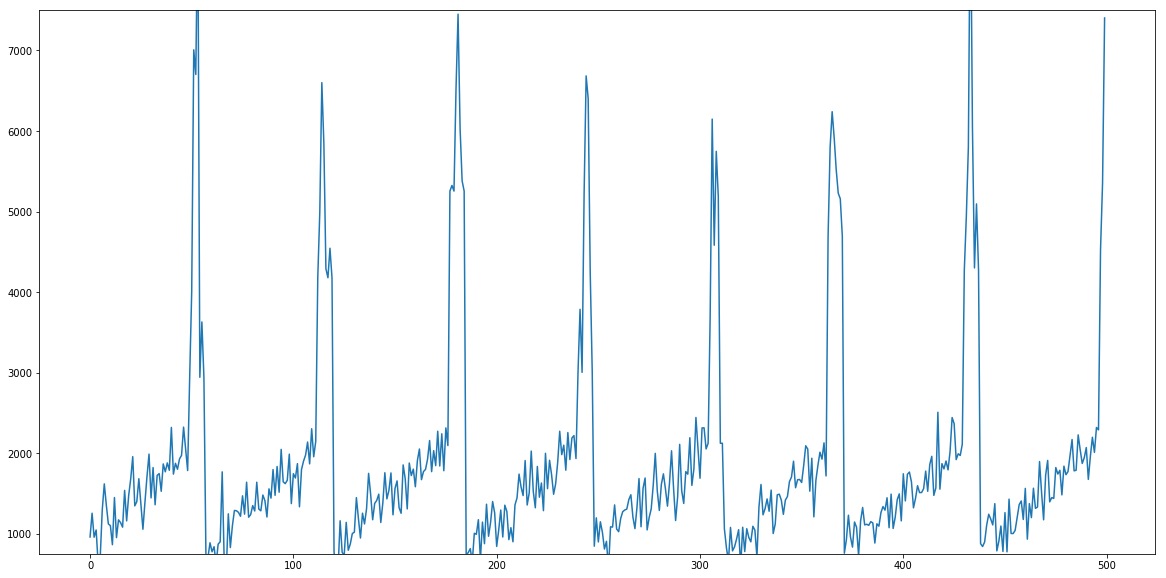

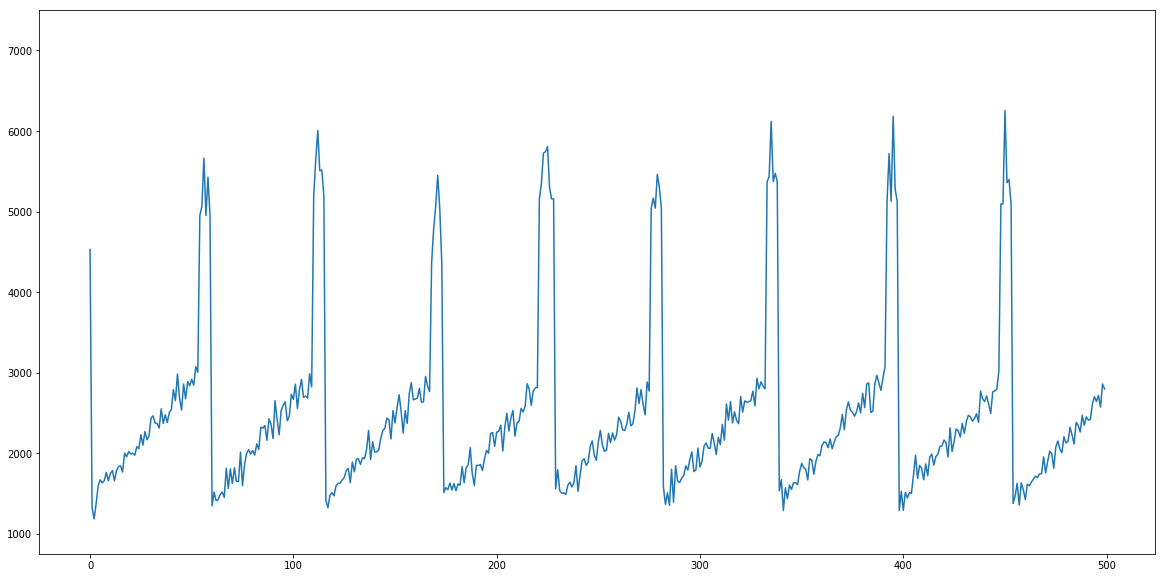

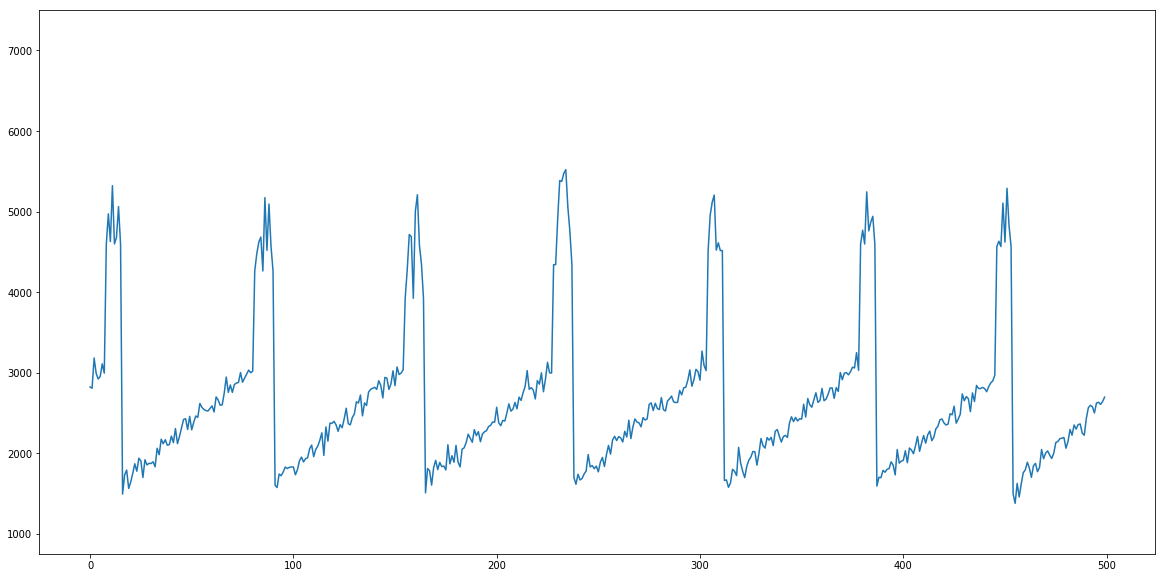

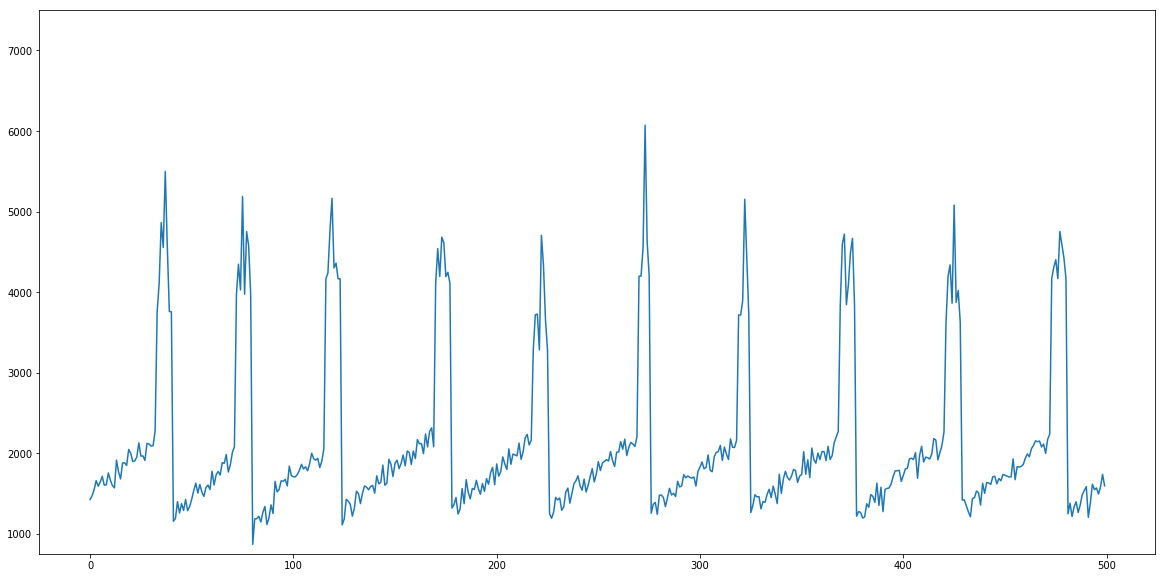

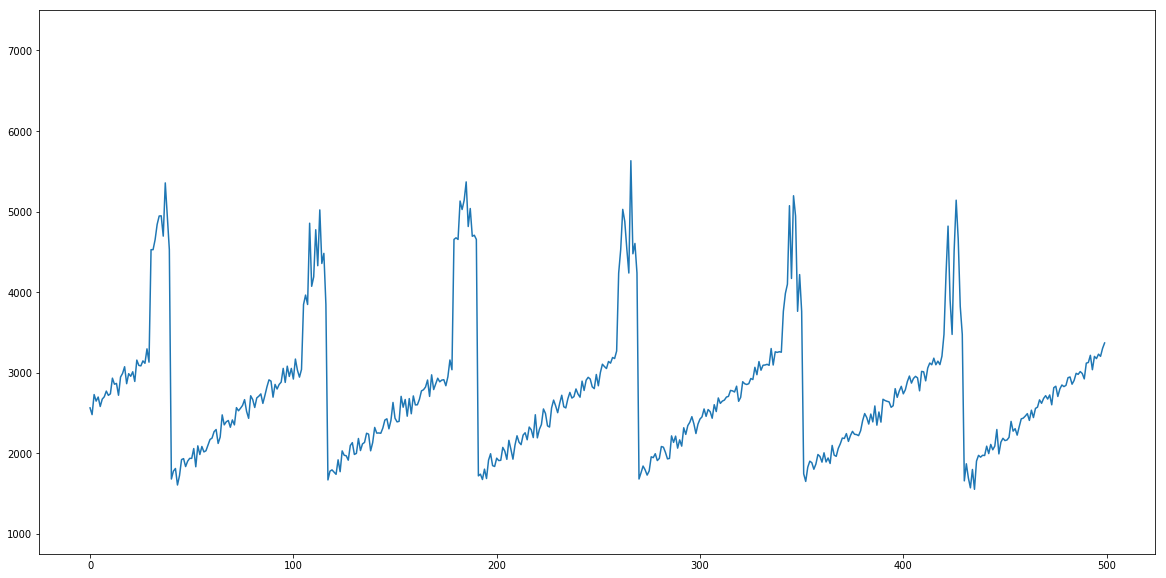

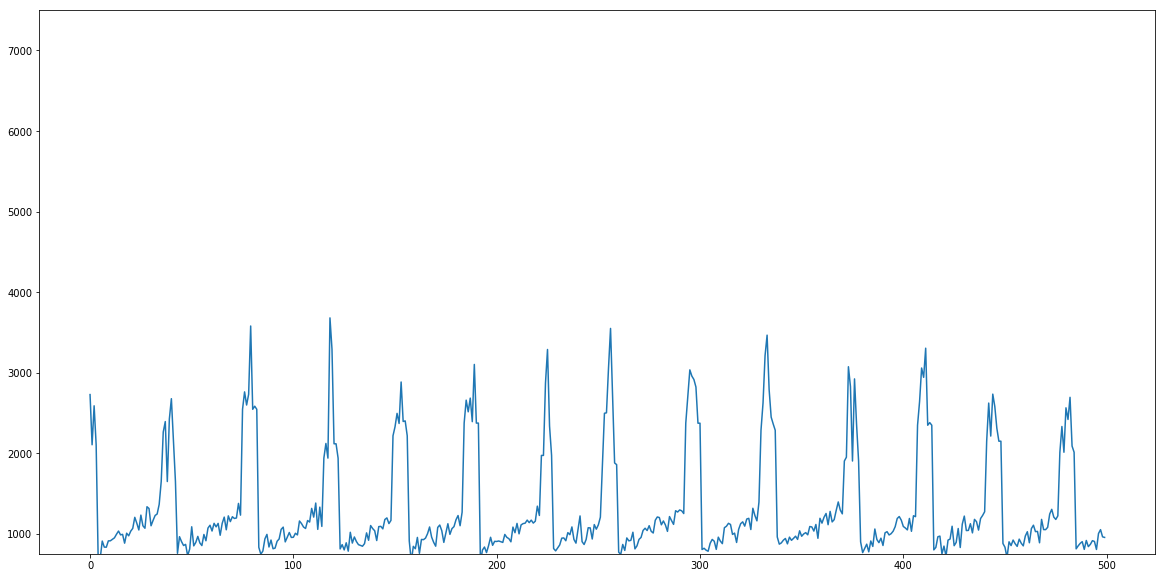

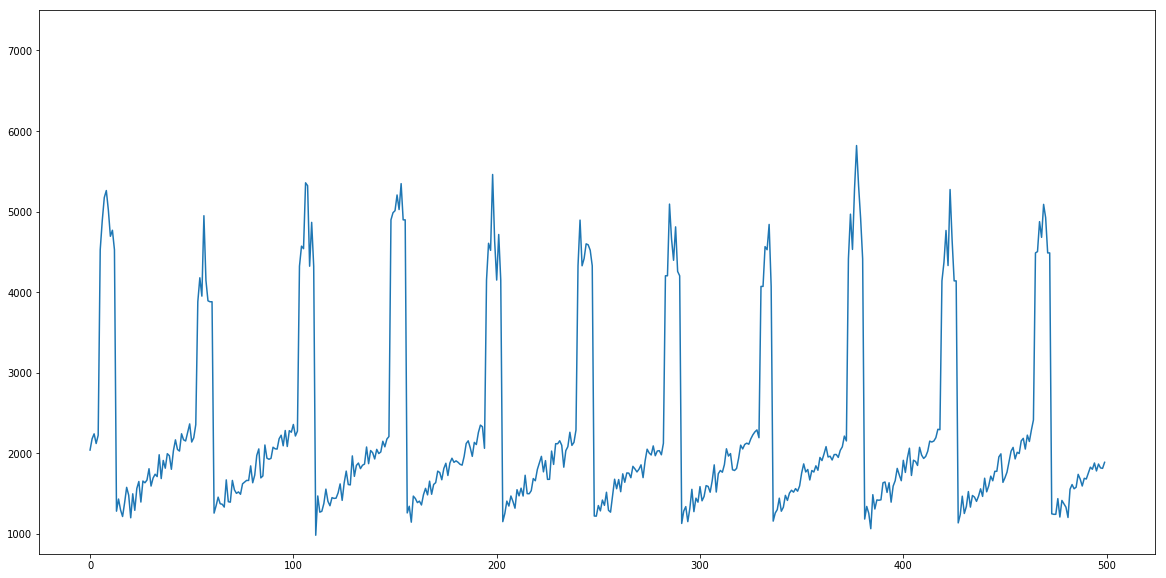

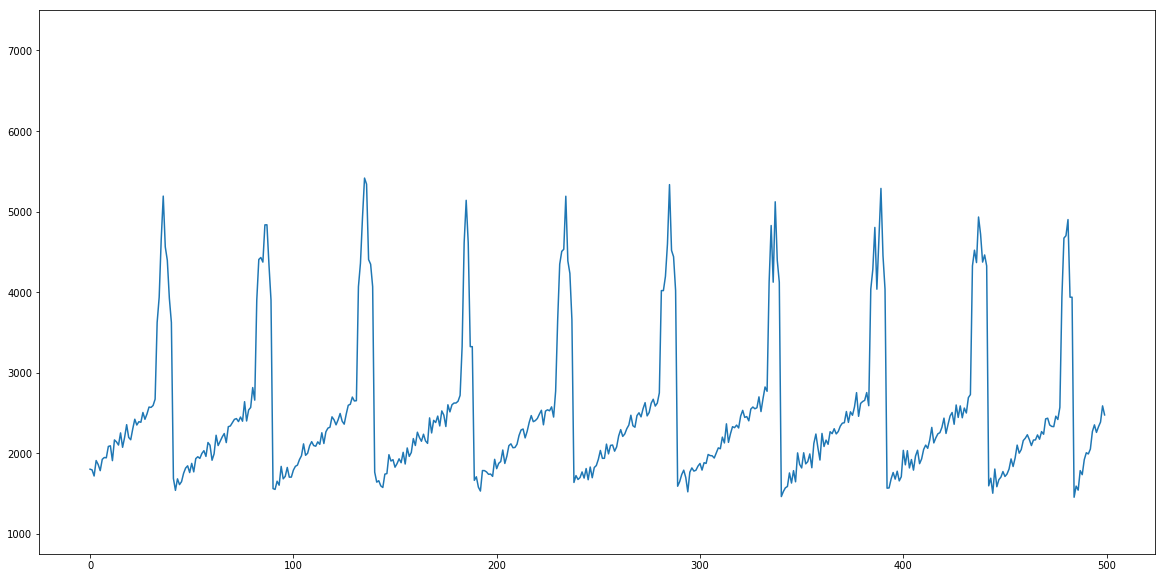

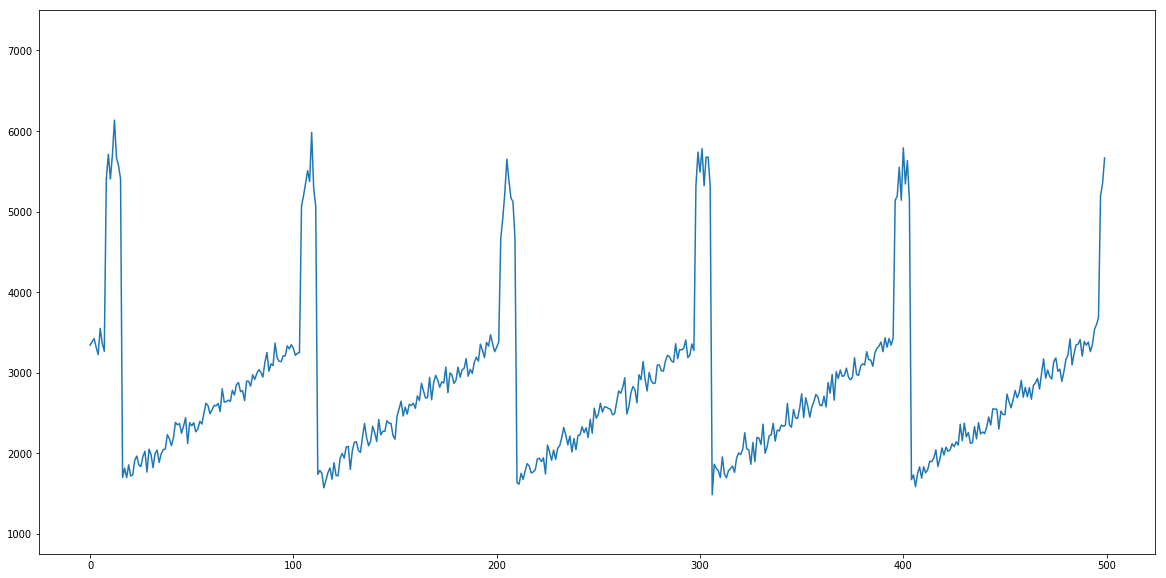

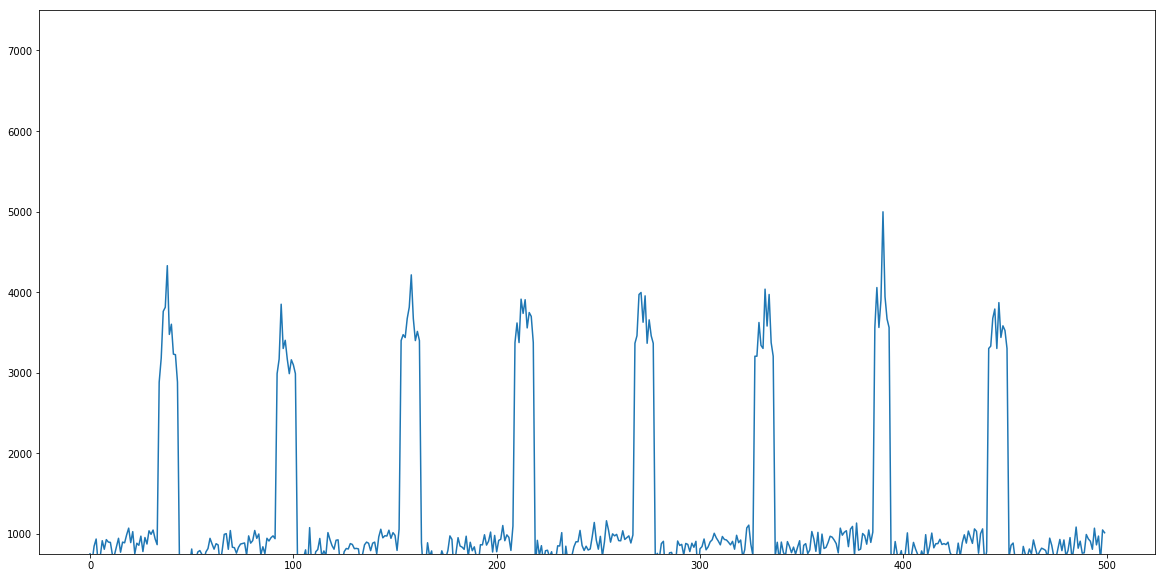

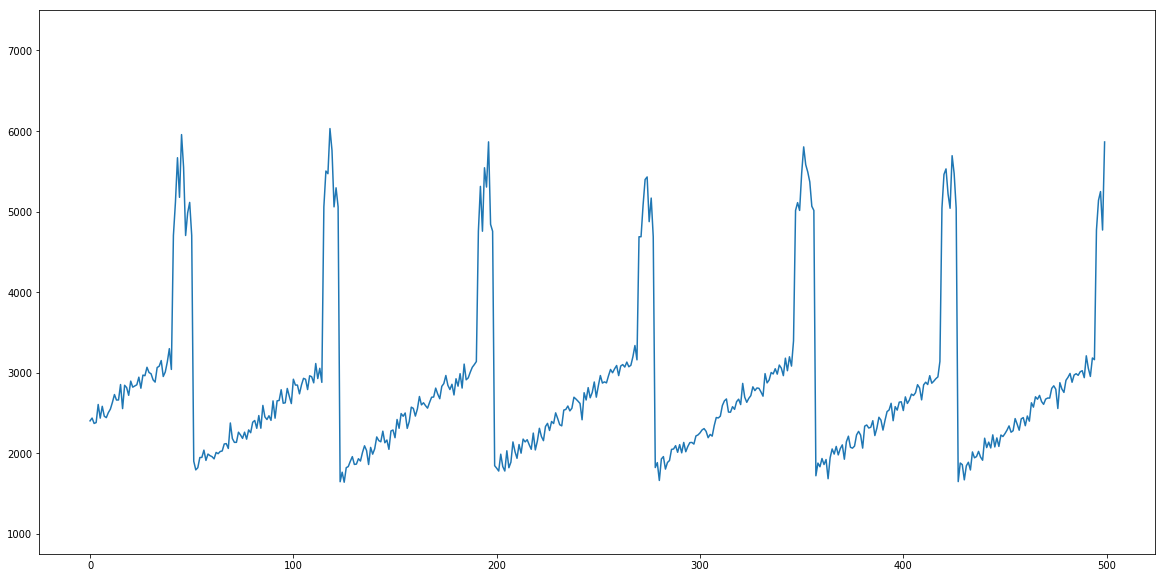

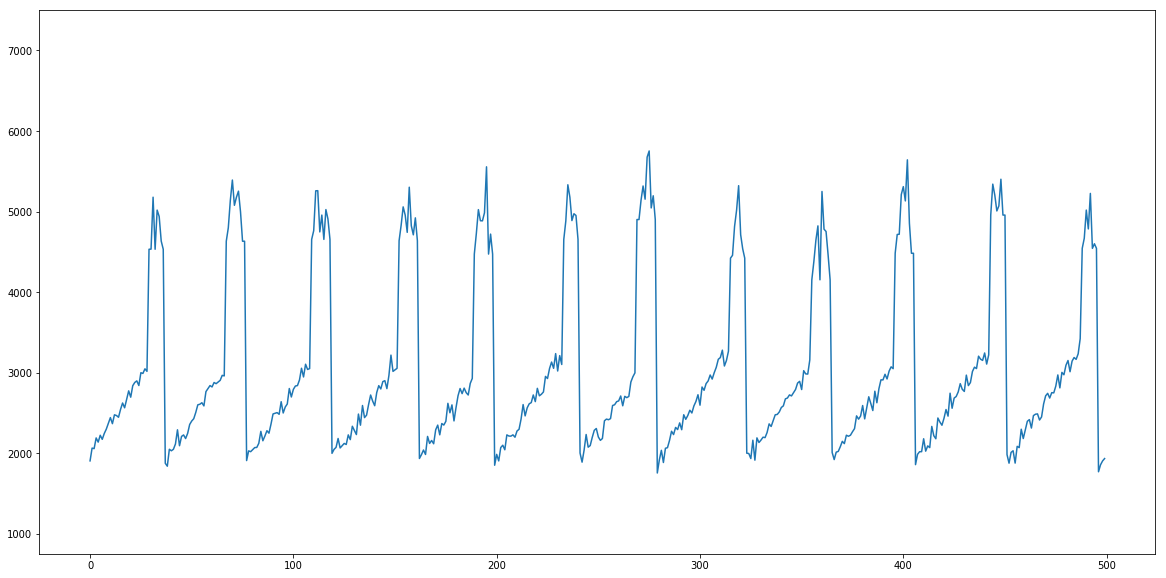

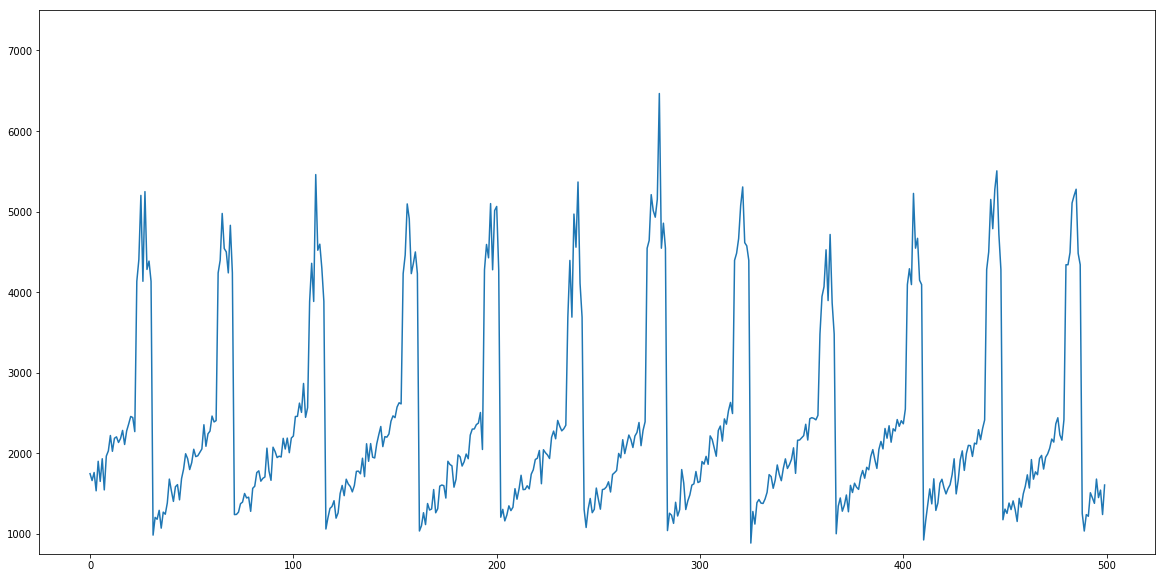

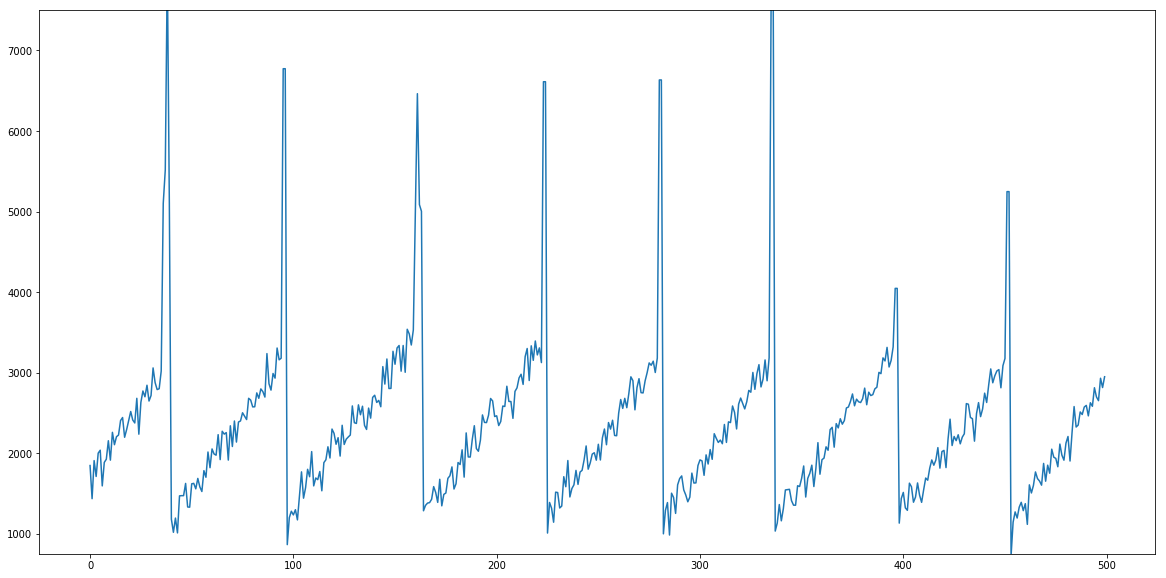

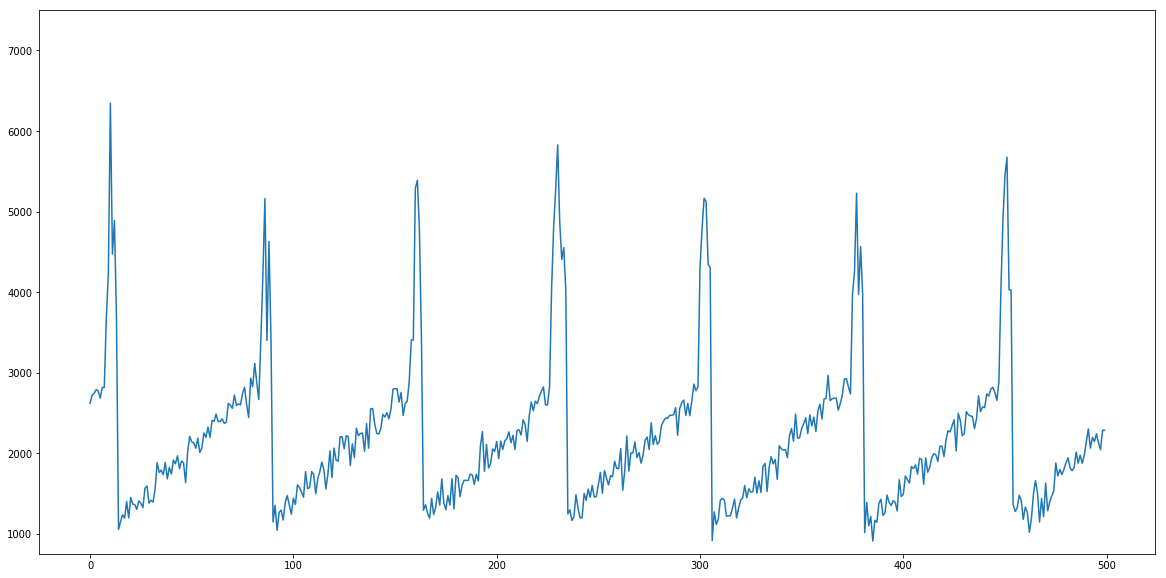

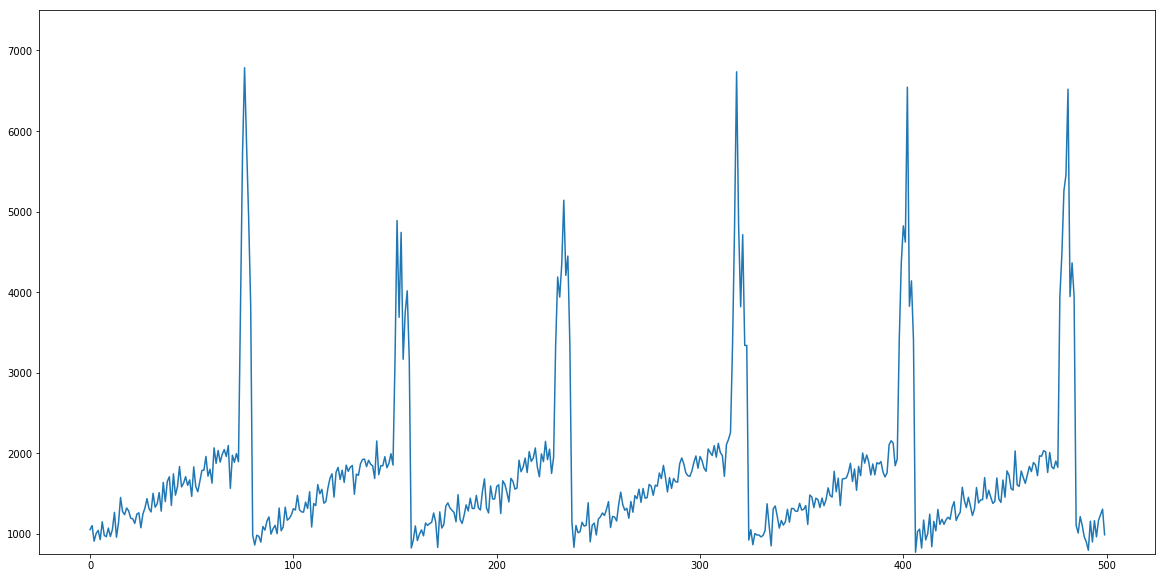

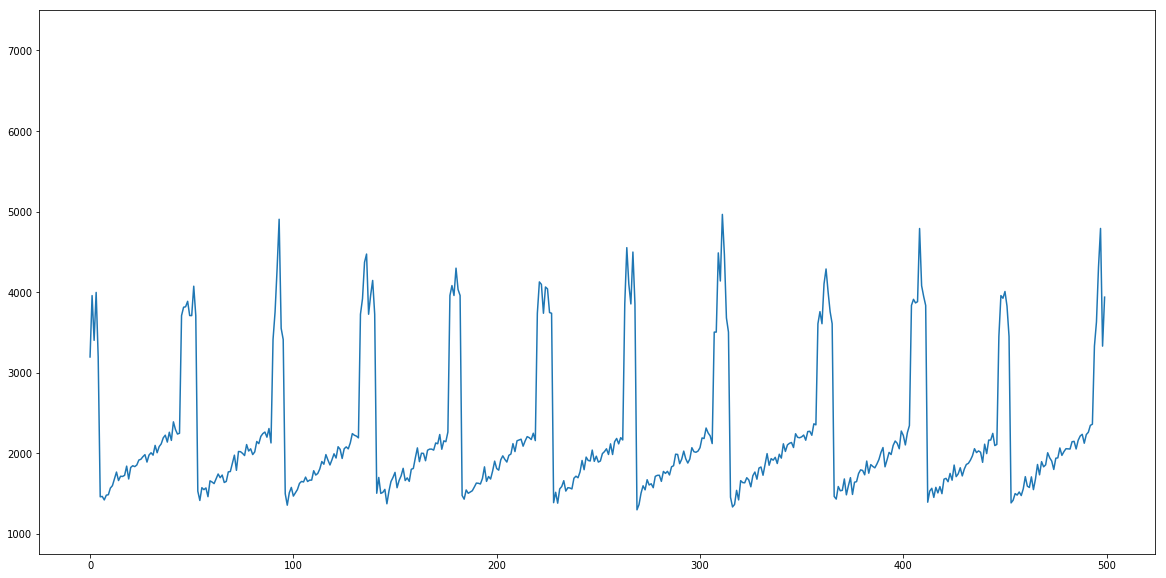

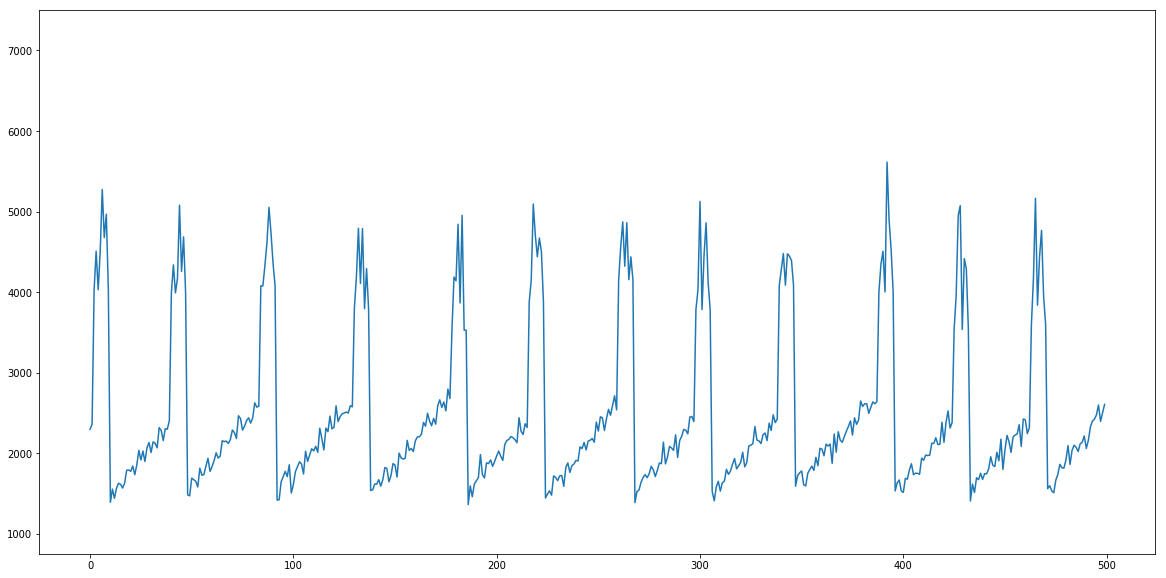

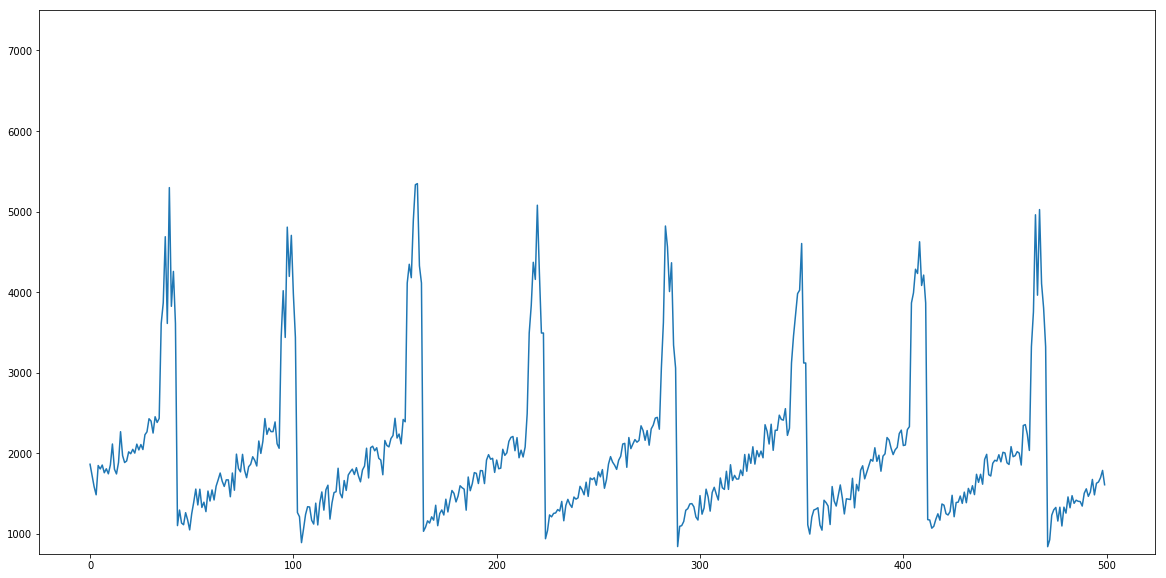

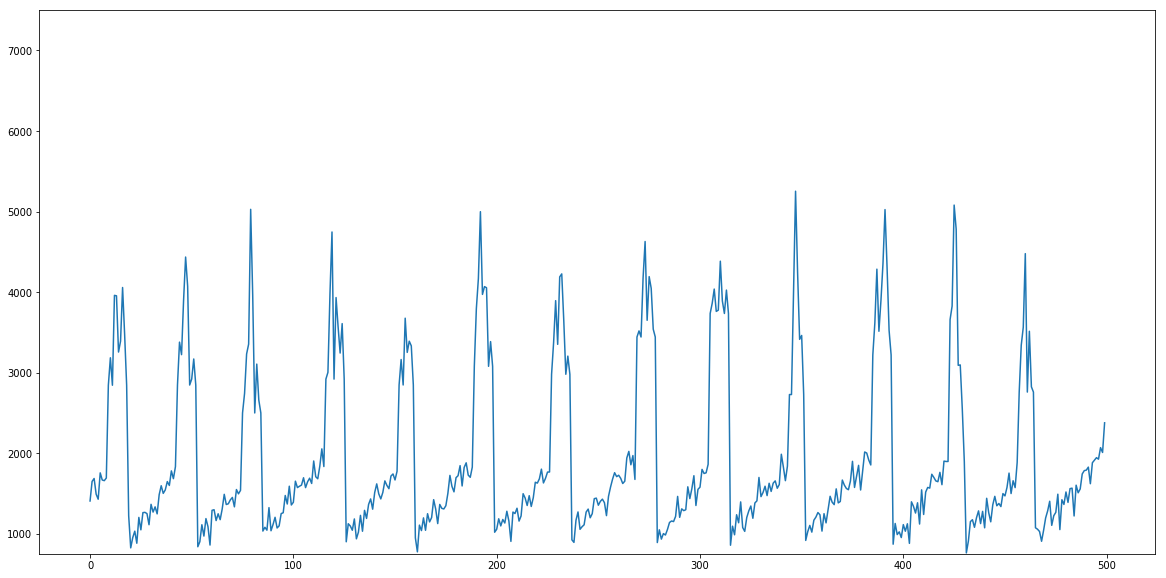

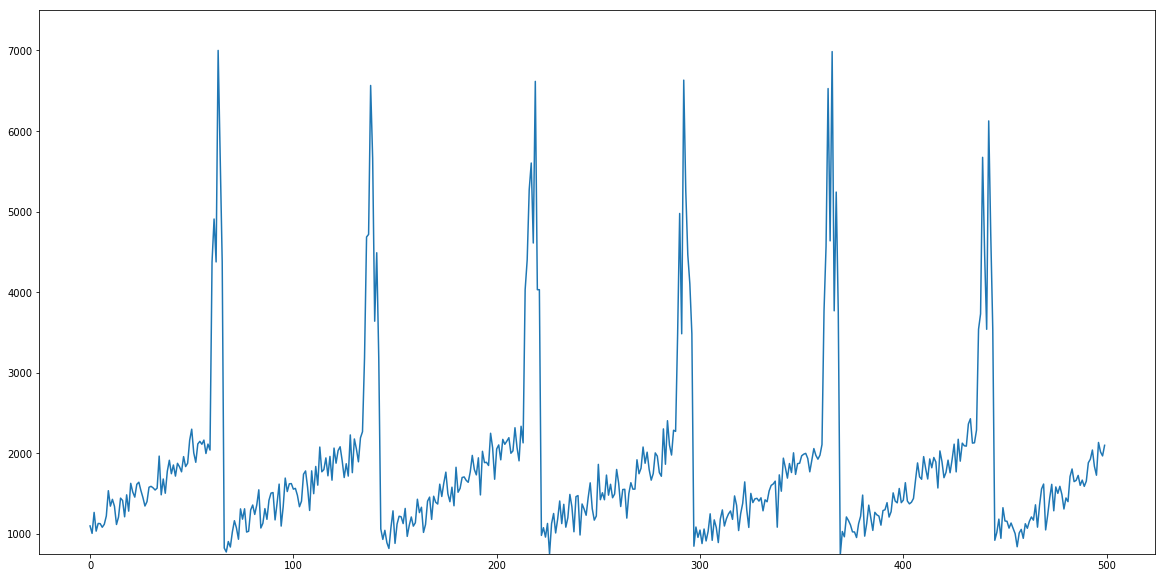

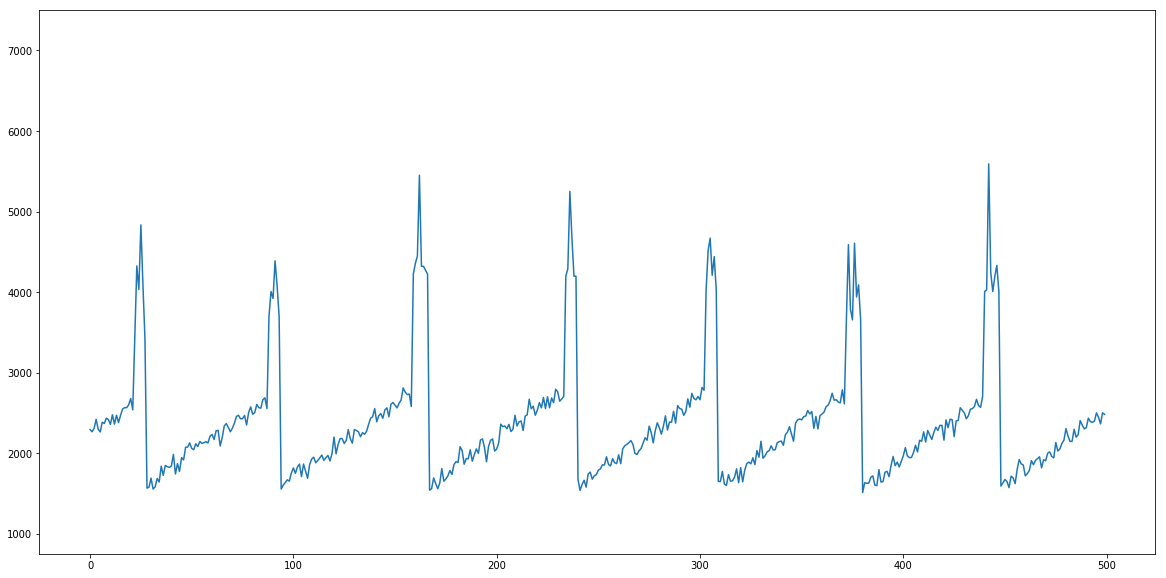

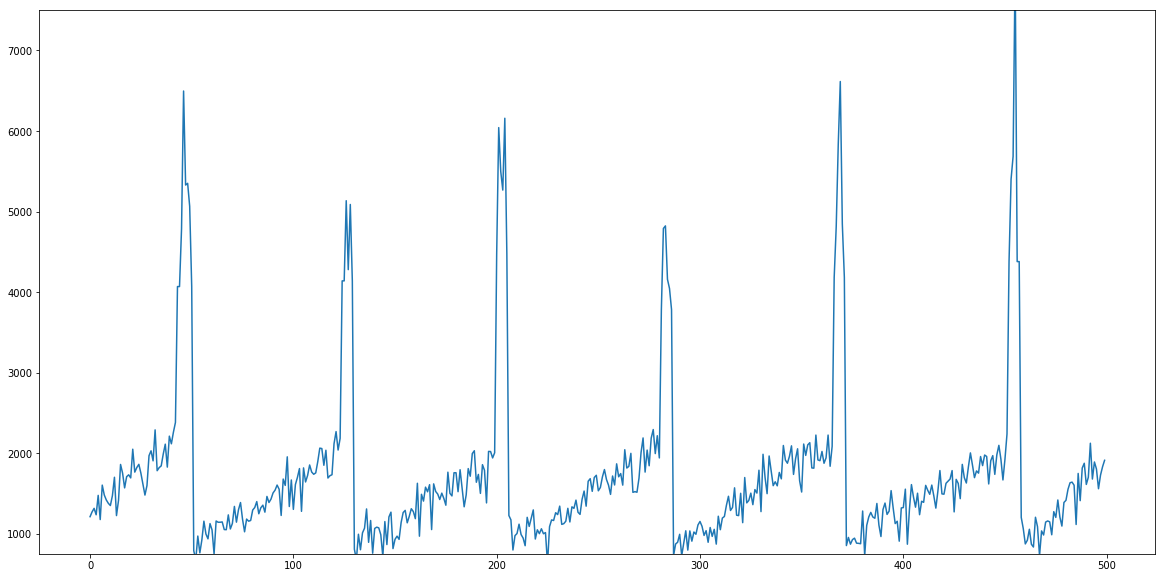

In [129]:
for synthro in range(50):
    plt.figure(figsize=(20,10))
    plt.plot(range(500), synthetic_rhos[synthro])
    plt.ylim([750,7500])
    #plt.show()
    plt.savefig("rho_lightcurves/synthetic/{}.png".format(synthro))

In [84]:
#mean_rates_list=[]#mean count rates for the entire lighcurve
    # std_rates_list=[]#standard deviation of count rates for the entire lighcurve
    

array([1046.22516562, 1026.1054509 , 1005.98573617,  985.86602145,
        965.74630673,  945.626592  ,  925.50687728,  905.38716255,
        885.26744783,  865.14773311,  845.02801838,  824.90830366,
        804.78858894,  784.66887421,  764.54915949,  744.42944477,
        724.30973004,  704.19001532,  684.0703006 ,  663.95058587,
        643.83087115,  623.71115643,  603.5914417 ,  583.47172698,
        563.35201226,  543.23229753,  523.11258281,  502.99286809,
        482.87315336,  462.75343864,  442.63372392,  422.51400919,
        402.39429447,  382.27457975,  362.15486502,  342.0351503 ,
        321.91543558,  301.79572085,  281.67600613,  261.5562914 ,
        241.43657668,  221.31686196,  201.19714723,  181.07743251,
        160.95771779,  140.83800306,  120.71828834,  100.59857362,
         80.47885889,   60.35914417,   40.23942945,   20.11971472,
          0.        ])

In [133]:
np.shape(synthetic_rhos)

(1000, 500)

In [134]:
np.savetxt("synthetic_rhos.csv" ,synthetic_rhos, delimiter=',')